In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import helpers as hp
import stationary as st
import plotresults as pr
import panel_var as pvar
import deepvar 
import var
import lstm
import warnings 
import irf

warnings.filterwarnings('ignore', category=UserWarning, module='statsmodels')
warnings.filterwarnings('ignore', message='X does not have valid feature names, but StandardScaler was fitted with feature names')
warnings.filterwarnings('ignore', message='An unsupported index was provided and will be ignored when e.g. forecasting.')

In [4]:
def prepare_df(df):
    df['log_GDP'] = np.log(df['GDP']) 
    df['log_CPI'] = np.log(df['CPI']) 
    final_df = df.copy()
    final_df['TIME_PERIOD'] = pd.to_datetime(final_df['TIME_PERIOD'])
    final_df = final_df.set_index(["Country", "TIME_PERIOD"])
    final_df = final_df.drop(columns = {"Code", "GDP", 'CPI'})
    return final_df



Basic VAR detrend results

In [5]:
df = pd.read_csv('./Data/WithoutPolicyRate.csv')

# panel_var_coef = pd.read_excel('./pvar/lag3/coef3.xlsx', index_col=0)

# # pr_df = pd.read_csv('./Data/WithPolicyRate.csv')

# # Calculate percent change by country for each variable
# pr_df['gdp_pct_change'] = pr_df.groupby('Country')['GDP'].pct_change() * 100
# pr_df['private_debt_pct_change'] = pr_df.groupby('Country')['private_debt'].pct_change() * 100
# pr_df['household_debt_pct_change'] = pr_df.groupby('Country')['household_debt'].pct_change() * 100
# pr_df['cpi_pct_change'] = pr_df.groupby('Country')['CPI'].pct_change() * 100

# pr_df['log_gdp'] = np.log(pr_df['GDP'])

# # Calculate the difference in log-transformed GDP by country
# pr_df['log_gdp_diff'] = pr_df.groupby('Country')['log_gdp'].diff()

variables_to_keep = ['log_GDP', 'household_debt', 'private_debt']
df[df["Code"] == "NL"]

TIME_PERIOD Code  private_debt  household_debt         CPI  \
77   1996-03-31 00:00:00   NL         157.5            68.0   74.695867   
78   1996-06-30 00:00:00   NL         157.8            69.4   75.249067   
79   1996-09-30 00:00:00   NL         157.8            70.3   75.321867   
80   1996-12-31 00:00:00   NL         158.0            71.6   75.827733   
81   1997-03-31 00:00:00   NL         160.1            76.0   76.122533   
..                   ...  ...           ...             ...         ...   
185  2023-03-31 00:00:00   NL         189.1           100.3  135.525467   
186  2023-06-30 00:00:00   NL         185.5            98.9  137.607233   
187  2023-09-30 00:00:00   NL         184.7            97.8  139.023000   
188  2023-12-31 00:00:00   NL         182.3            95.5  138.509833   
189  2024-03-31 00:00:00   NL         179.2            94.9  139.623500   

     exchange_rate           Country          GDP  
77       99.795000  Netherlands, The  115084.2034  
78       98.073333  Netherlands, The  116741.1160  
79       98.168333  Netherlands, The  118438.1721  
80       96.988333  Netherlands, The  119152.0704  
81       94.261667  Netherlands, The  120136.2542  
..             ...               ...          ...  
185     100.281667  Netherlands, The  199221.3622  
186     101.530000  Netherlands, The  198710.4875  
187     102.286667  Netherlands, The  197967.3169  
188     101.433333  Netherlands, The  198454.1428  
189     101.656667  Netherlands, The  197835.4134  

[113 rows x 8 columns]

In [6]:
df = prepare_df(df)
# pr_df = prepare_df(pr_df)
df = df.drop(columns = {"exchange_rate"})
df = df[variables_to_keep]
LAGS = 3


In [8]:
variables = df.columns
final_detrend = st.detrend_data(df, variables, 1) 
final_detrend = final_detrend[final_detrend.index.get_level_values("TIME_PERIOD")< "2020-03-31"]
countries_to_drop = ['Argentina', 'Türkiye, Rep of',  'Ireland']
final_detrend =  final_detrend[~final_detrend.index.get_level_values('Country').isin(countries_to_drop)]

Index(['Colombia', 'Netherlands, The', 'United Kingdom', 'India', 'Israel',
       'Sweden', 'Thailand', 'Australia', 'New Zealand', 'Ireland', 'Germany',
       'Brazil', 'Mexico', 'Greece', 'Norway', 'Austria', 'Italy', 'Argentina',
       'Singapore', 'France', 'Portugal', 'Hungary', 'Spain', 'Canada',
       'Switzerland', 'United States', 'Denmark', 'Indonesia',
       'China, P.R.: Hong Kong', 'Luxembourg', 'Japan', 'Finland',
       'South Africa', 'Chile', 'Czech Rep.', 'Poland, Rep. of',
       'Türkiye, Rep of', 'Korea, Rep. of', 'Belgium'],
      dtype='object', name='Country')


In [7]:
var.aic_test(final_detrend)

[1,
 8,
 4,
 8,
 5,
 5,
 8,
 6,
 1,
 5,
 2,
 2,
 2,
 8,
 1,
 8,
 1,
 4,
 4,
 8,
 5,
 5,
 2,
 8,
 6,
 4,
 2,
 6,
 1,
 6,
 8,
 1,
 5,
 5,
 8,
 2]

In [8]:
train_dt_var, test_dt_var = hp.time_panel_split_predict(final_detrend)
excluding_outlier = hp.exclude_country(final_detrend,"Indonesia")
excluding_outliers = hp.exclude_country(final_detrend,"India")
eo_train_dt_var, eo_test_dt_var = hp.time_panel_split_predict(excluding_outliers)

lstm_df= lstm.create_lstm_data(final_detrend, 3)


inputs = lstm.get_lstm_input(final_detrend, 3)
lstm_train, lstm_val, lstm_test= lstm.train_val_test_split(lstm_df)


lstm_df_window = lstm.create_lstm_data(final_detrend, 1)
inputs_window = lstm.get_lstm_input(final_detrend, 1)
lstm_train_window, lstm_val_window, lstm_test_window= lstm.train_val_test_split(lstm_df_window)


In [9]:
num_unique_countries = len(final_detrend.index.get_level_values("Country").unique())
print("Countries", num_unique_countries)
print("Number of obsevations", len(final_detrend))
# all_lstm_data.index.get_level_values("TIME_PERIOD").unique().sort_values()

Countries 36
Number of obsevations 3844


In [10]:
final_detrend.describe()

summary_stats = final_detrend.describe().transpose()

latex_table = summary_stats.to_latex(float_format="%.5f")

# Print the LaTeX code (you can copy this directly into your LaTeX document)
print(latex_table)

\begin{tabular}{lrrrrrrrr}
\toprule
 & count & mean & std & min & 25% & 50% & 75% & max \\
\midrule
log_GDP & 3844.00000 & 0.00639 & 0.01036 & -0.07151 & 0.00166 & 0.00676 & 0.01147 & 0.08968 \\
household_debt & 3844.00000 & 0.26783 & 0.77187 & -3.50000 & -0.20000 & 0.20000 & 0.70000 & 4.40000 \\
private_debt & 3844.00000 & 0.32226 & 2.41855 & -14.10000 & -0.70000 & 0.20000 & 1.10000 & 30.80000 \\
\bottomrule
\end{tabular}



In [11]:
# all_lstm_data[all_lstm_data['private_debt']>10]
# # Ireland 2015 corporate debt restructuring. Should I omit?
# all_lstm_data[all_lstm_data['CPI']>10]
# #  Turkey and Argentina

# all_lstm_data[all_lstm_data['log_GDP']>0.15]
# # Pandemic bouncebacks
# # Pandemic crash
# all_lstm_data[all_lstm_data['log_GDP']<-0.15]

# all_lstm_data[all_lstm_data['household_debt']<-4]

# all_lstm_data[all_lstm_data['private_debt']<-10]

# recession = all_lstm_data[all_lstm_data['log_GDP']< -.01]

# average_household_debt_recession = recession['log_hhd'].mean()
# average_household_debt_recession 


In [12]:
param_dict = {
    'household_debt':{'learning_rate': 0.005, 'epochs': 50},
    'log_GDP':{'learning_rate': 0.0009, 'epochs': 50},
    'private_debt': {'learning_rate': .003, 'epochs': 50},
    # 'policy_rate': {'learning_rate': .003, 'epochs': 50},
}

In [13]:


lstm_df


log_GDP  household_debt  private_debt  log_GDP_lag1  \
Country  TIME_PERIOD                                                         
Colombia 2005-06-30   0.020220           0.494        -0.682           NaN   
         2005-09-30  -0.000439           0.320        -0.743      0.020220   
         2005-12-31   0.018095           0.690        -0.278     -0.000439   
         2006-03-31   0.021254          -0.076        -0.160      0.018095   
         2006-06-30   0.016457           0.713         0.660      0.021254   
...                        ...             ...           ...           ...   
Belgium  2018-12-31   0.009724           0.300         0.900      0.003900   
         2019-03-31   0.002609           0.400        -0.200      0.009724   
         2019-06-30   0.005386           0.300        -0.900      0.002609   
         2019-09-30   0.007315           0.000         2.300      0.005386   
         2019-12-31   0.005931           0.700        -1.400      0.007315   

                      log_GDP_lag2  log_GDP_lag3  household_debt_lag1  \
Country  TIME_PERIOD                                                    
Colombia 2005-06-30            NaN           NaN                  NaN   
         2005-09-30            NaN           NaN                0.494   
         2005-12-31       0.020220           NaN                0.320   
         2006-03-31      -0.000439      0.020220                0.690   
         2006-06-30       0.018095     -0.000439               -0.076   
...                            ...           ...                  ...   
Belgium  2018-12-31       0.004515      0.003720               -0.100   
         2019-03-31       0.003900      0.004515                0.300   
         2019-06-30       0.009724      0.003900                0.400   
         2019-09-30       0.002609      0.009724                0.300   
         2019-12-31       0.005386      0.002609                0.000   

                      household_debt_lag2  household_debt_lag3  \
Country  TIME_PERIOD                                             
Colombia 2005-06-30                   NaN                  NaN   
         2005-09-30                   NaN                  NaN   
         2005-12-31                 0.494                  NaN   
         2006-03-31                 0.320                0.494   
         2006-06-30                 0.690                0.320   
...                                   ...                  ...   
Belgium  2018-12-31                 0.400               -0.300   
         2019-03-31                -0.100                0.400   
         2019-06-30                 0.300               -0.100   
         2019-09-30                 0.400                0.300   
         2019-12-31                 0.300                0.400   

                      private_debt_lag1  private_debt_lag2  private_debt_lag3  
Country  TIME_PERIOD                                                           
Colombia 2005-06-30                 NaN                NaN                NaN  
         2005-09-30              -0.682                NaN                NaN  
         2005-12-31              -0.743             -0.682                NaN  
         2006-03-31              -0.278             -0.743             -0.682  
         2006-06-30              -0.160             -0.278             -0.743  
...                                 ...                ...                ...  
Belgium  2018-12-31              -3.400              0.300             -3.000  
         2019-03-31               0.900             -3.400              0.300  
         2019-06-30              -0.200              0.900             -3.400  
         2019-09-30              -0.900             -0.200              0.900  
         2019-12-31               2.300             -0.900             -0.200  

[3844 rows x 12 columns]

## Get Metrics for Log_GDP


Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  32%|███▏      | 32/100 [00:00<00:00, 79.50it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 39 steps due to diverging loss.
Finding best initial lr:  39%|███▉      | 39/100 [00:01<00:01, 31.77it/s]
Learning rate set to 0.00012022644346174131
Restoring states from the checkpoint path at /

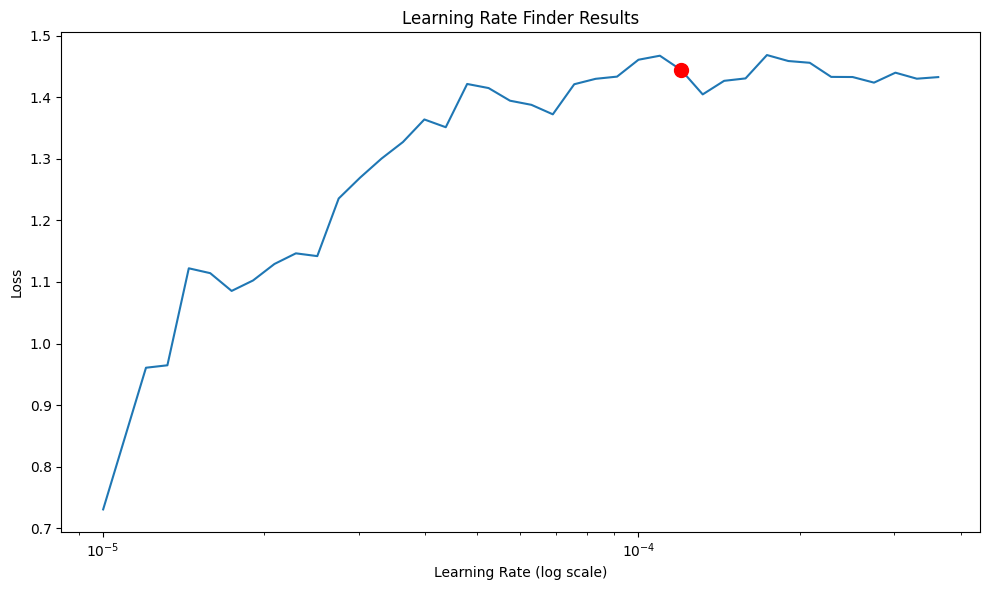

Seed set to 18
Seed set to 18
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/lstm.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).to(device)
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/lstm.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).to(device)
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/lstm.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than

Suggested learning rate: 0.00012023


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

NameError: name 'exit' is not defined

In [14]:
best_lr = lstm.find_learning_rate(lstm_df, inputs, 'log_GDP',min_lr=1e-5, max_lr=1e-1)

GDP_model_lstm, GDP_predictions_lstm, GDP_lstm_metrics, GDP_scaler_X, GDP_scaler_y = lstm.train_lstm_model(lstm_df, inputs, ['log_GDP'], learning_rate = best_lr, num_epochs= 500)

best_lr_window = lstm.find_learning_rate(lstm_df, inputs_window, 'log_GDP', min_lr=1e-5, max_lr=1e-1)

GDP_model_lstm_window, GDP_predictions_lstm_window, GDP_lstm_metrics_window, GDP_scaler_X_window, GDP_scaler_y_window = lstm.train_lstm_model(lstm_df_window, inputs_window, ['log_GDP'], learning_rate = best_lr_window, num_epochs= 500)


GDP_var_metrics = var.get_test_errors(final_detrend, train_dt_var, test_dt_var, LAGS, 'log_GDP')
GDP_no_outlier_var_metrics = var.get_test_errors(excluding_outliers, train_dt_var, test_dt_var, LAGS, 'log_GDP')
# GDP_pvar_metrics= pvar.get_test_errors(lstm_df, lstm_test, LAGS, 'log_GDP', panel_var_coef)



## Get Metrics for Household Debt

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/200], Train Loss: 0.7172, Val Loss: 0.4255
Epoch [20/200], Train Loss: 0.7140, Val Loss: 0.3976
Epoch [30/200], Train Loss: 0.7039, Val Loss: 0.4036
Epoch [40/200], Train Loss: 0.7149, Val Loss: 0.4033
Epoch [50/200], Train Loss: 0.6944, Val Loss: 0.4089
Epoch [60/200], Train Loss: 0.7349, Val Loss: 0.4088
Epoch [70/200], Train Loss: 0.7004, Val Loss: 0.4047
Epoch [80/200], Train Loss: 0.7163, Val Loss: 0.4097
Epoch [90/200], Train Loss: 0.6994, Val Loss: 0.4080
Epoch [100/200], Train Loss: 0.7050, Val Loss: 0.4039
Epoch [110/200], Train Loss: 0.6807, Val Loss: 0.4094
Epoch [120/200], Train Loss: 0.6982, Val Loss: 0.4118
Epoch [130/200], Train Loss: 0.6976, Val Loss: 0.4055
Epoch [140/200], Train Loss: 0.7044, Val Loss: 0.4035
Epoch [150/200], Train Loss: 0.7017, Val Loss: 0.4083
Epoch [160/200], Train Loss: 0.6989, Val Loss: 0.4029
Epoch [170/200], Train Loss: 0.7103, Val Loss: 0.4103
Epoch [180/200], Train Loss: 0.6951, Val Loss: 0.4045
Epoch [190/200], Train Loss: 0.7003, 

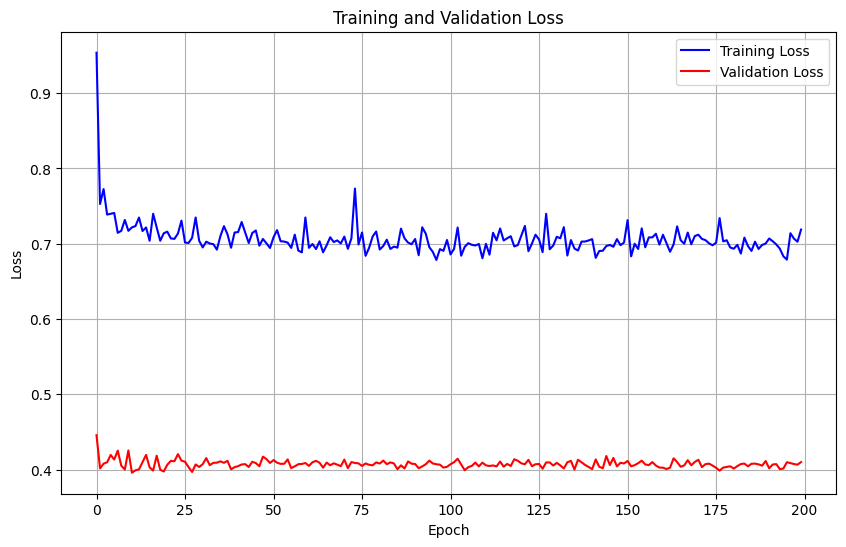

Final LSTM Metrics:
MSE: 0.2676985
RMSE: 0.51739585
MAE: 0.3739888


/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:49: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:49: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:49: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:49: FutureWarning

NameError: name 'panel_var_coef' is not defined

In [13]:
hhd_model_lstm, hhd_predictions_lstm, hhd_lstm_metrics, hhd_scaler_X, hhd_scaler_y = lstm.train_lstm_model(lstm_df, inputs, ['household_debt'], .003, num_epochs= 200)
hhd_var_metrics = var.get_test_errors(final_detrend, train_dt_var, test_dt_var, 3, 'household_debt')
hhd_no_outlier_var_metrics = var.get_test_errors(excluding_outliers, train_dt_var, test_dt_var, 3, 'household_debt')
# hhd_pvar_metrics= pvar.get_test_errors(lstm_df, lstm_test, LAGS, 'household_debt', panel_var_coef)

## Get Metrics for Private Debt

In [16]:
fd_model_lstm, fd_predictions_lstm, fd_lstm_metrics, fd_scaler_X, fd_scaler_y = lstm.train_lstm_model(lstm_df, inputs, ['private_debt'], .003, num_epochs= 100)
fd_var_metrics = var.get_test_errors(final_detrend, train_dt_var, test_dt_var, 3, 'private_debt')
fd_no_outlier_var_metrics  = var.get_test_errors(excluding_outliers, train_dt_var, test_dt_var, 3, 'private_debt')
# fd_pvar_metrics= pvar.get_test_errors(lstm_df, lstm_test, LAGS, 'private_debt', panel_var_coef)


Seed set to 18
Seed set to 18
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/lstm.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).to(device)
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/lstm.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).to(device)
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/lstm.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than

Final LSTM Metrics:
MSE: 5.4043474
RMSE: 2.3247252
MAE: 1.4181437
[5.4043474, 2.3247252, 1.4181437]


/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:49: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:49: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:49: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:49: FutureWarning

[5.9697195676799995, 2.4433009572461595, 1.5435411615505157]

In [17]:
print(fd_lstm_metrics)
fd_var_metrics

[5.4043474, 2.3247252, 1.4181437]


[5.9697195676799995, 2.4433009572461595, 1.5435411615505157]

In [14]:
# pr_model_lstm, pr_predictions_lstm, pr_mse, pr_rmse, pr_mae, pr_scaler_X, pr_scaler_y= train_lstm_model(all_lstm_data, inputs, ['policy_rate'], .002, num_epochs= 200)

# fd_var_metrics = var.get_test_errors(final_detrend, train_dt_var, test_dt_var, 3, 'private_debt')
# fd_no_outlier_var_metrics  = var.get_test_errors(excluding_outliers, train_dt_var, test_dt_var, 3, 'private_debt')


Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/50], Train Loss: 0.8733, Val Loss: 0.2981
Epoch [20/50], Train Loss: 0.8637, Val Loss: 0.2984
Epoch [30/50], Train Loss: 0.8725, Val Loss: 0.2993
Epoch [40/50], Train Loss: 0.8808, Val Loss: 0.3000
Epoch [50/50], Train Loss: 0.8531, Val Loss: 0.2999


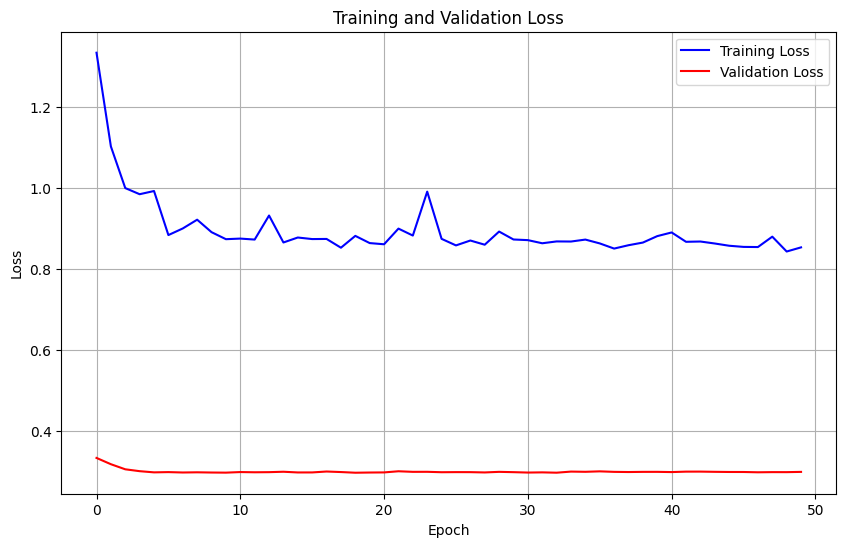

Seed set to 18
Seed set to 18


Final LSTM Metrics:
MSE: 3.851233e-05
RMSE: 0.0062058303
MAE: 0.004329462


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/50], Train Loss: 0.7150, Val Loss: 0.4203
Epoch [20/50], Train Loss: 0.7098, Val Loss: 0.4063
Epoch [30/50], Train Loss: 0.6989, Val Loss: 0.4044
Epoch [40/50], Train Loss: 0.7063, Val Loss: 0.4095
Epoch [50/50], Train Loss: 0.6861, Val Loss: 0.4115


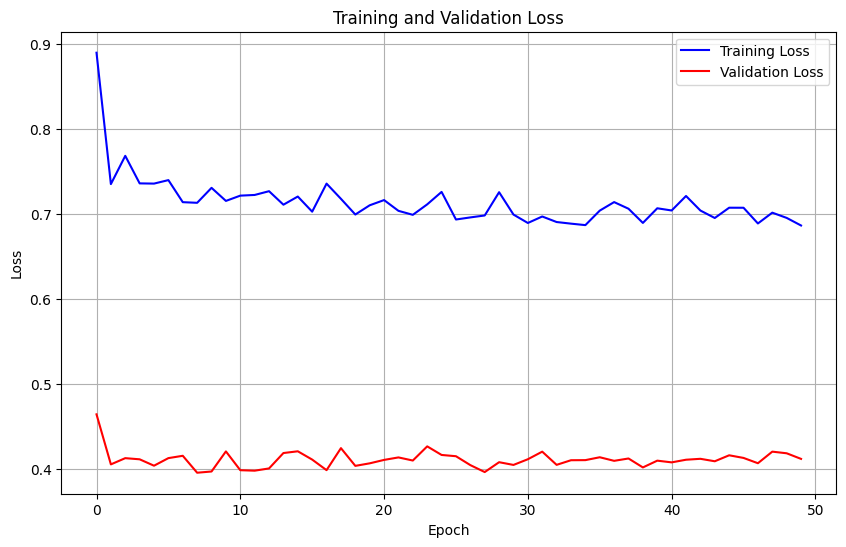

Seed set to 18
Seed set to 18


Final LSTM Metrics:
MSE: 0.26840785
RMSE: 0.51808095
MAE: 0.3742421


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/50], Train Loss: 0.8818, Val Loss: 0.9247
Epoch [20/50], Train Loss: 0.8804, Val Loss: 0.9161
Epoch [30/50], Train Loss: 0.8309, Val Loss: 0.9176
Epoch [40/50], Train Loss: 0.8407, Val Loss: 0.9152
Epoch [50/50], Train Loss: 0.8111, Val Loss: 0.9264


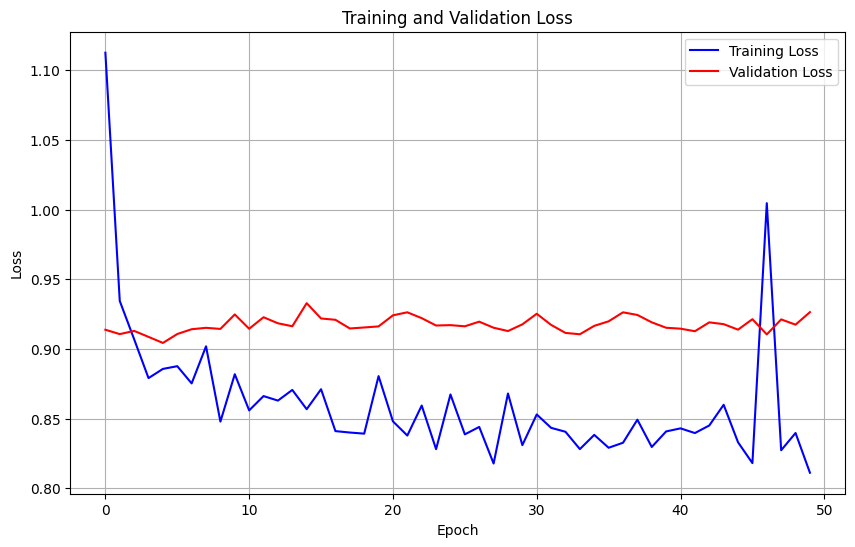

Final LSTM Metrics:
MSE: 5.3925767
RMSE: 2.3221922
MAE: 1.4092977


In [15]:
variables = final_detrend.columns
model_scaler_dict = deepvar.get_model_and_scaler(lstm_df, variables, inputs, param_dict)

In [16]:
inputsvar = final_detrend.columns
print(inputsvar)
gdp_deepvar_metrics = deepvar.test_errors(lstm_df, lstm_test, 'log_GDP', model_scaler_dict, inputsvar)
hhd_deepvar_metrics = deepvar.test_errors(lstm_df, lstm_test, 'household_debt', model_scaler_dict, inputsvar)
fd_deepvar_metrics = deepvar.test_errors(lstm_df, lstm_test, 'private_debt', model_scaler_dict,inputsvar)

Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18


Index(['log_GDP', 'household_debt', 'private_debt'], dtype='object')


Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set t

In [17]:
gdp_latex_comparison_table = hp.create_model_comparison_latex_table(gdp_deepvar_metrics, GDP_var_metrics, GDP_no_outlier_var_metrics, GDP_pvar_metrics)
print(gdp_latex_comparison_table)

hhd_latex_comparison_table = hp.create_model_comparison_latex_table(hhd_deepvar_metrics, hhd_var_metrics, hhd_no_outlier_var_metrics, hhd_pvar_metrics)
print(hhd_latex_comparison_table)

fd_latex_comparison_table = hp.create_model_comparison_latex_table(fd_deepvar_metrics, fd_var_metrics, fd_no_outlier_var_metrics, fd_pvar_metrics)
print(fd_latex_comparison_table)


\begin{table}[htbp]
\centering
\caption{Model Performance Comparison}
\begin{tabular}{lccc}
\hline
\textbf{Metric} & \textbf{DeepVAR} & \textbf{VAR} & \textbf{VAR (Excluding Growth Outliers)} & \textbf{Panel VAR} \\
\hline
Mean Squared Error (MSE) & 0.000040 & 0.000046 & 0.000046 & 0.000075 \\
Root Mean Squared Error (RMSE) & 0.006336 & 0.006803 & 0.006779 & 0.008676 \\
Mean Absolute Error (MAE) & 0.004483 & 0.004743 & 0.004704 & 0.007051 \\
\hline
\end{tabular}
\end{table}
\begin{table}[htbp]
\centering
\caption{Model Performance Comparison}
\begin{tabular}{lccc}
\hline
\textbf{Metric} & \textbf{DeepVAR} & \textbf{VAR} & \textbf{VAR (Excluding Growth Outliers)} & \textbf{Panel VAR} \\
\hline
Mean Squared Error (MSE) & 0.425959 & 0.537780 & 0.522158 & 0.405640 \\
Root Mean Squared Error (RMSE) & 0.652656 & 0.733335 & 0.722605 & 0.636898 \\
Mean Absolute Error (MAE) & 0.481157 & 0.516619 & 0.509957 & 0.444418 \\
\hline
\end{tabular}
\end{table}
\begin{table}[htbp]
\centering
\caption{Mo

In [18]:
def calculate_percent_improvement(deepvar_metrics, compare_metrics):
    improvements = {}
    
    # Define the metric names for clarity (order should match the input lists)
    metric_names = ['total_mse', 'rmse', 'total_mae']
    
    for i, metric in enumerate(metric_names):
        # Get the values for DeepVAR and the comparison model
        deepvar_value = deepvar_metrics[i]
        compare_value = compare_metrics[i]
        
        if compare_value != 0:  
            improvement = ((compare_value - deepvar_value) / compare_value) * 100
            improvements[metric] = improvement
        else:
            improvements[metric] = None  
    
    return improvements

improvement_deepvar_vs_var_gdp = calculate_percent_improvement(gdp_deepvar_metrics, GDP_var_metrics)
print("GDP model improvement",improvement_deepvar_vs_var_gdp)


improvement_deepvar_vs_var_hhd = calculate_percent_improvement(hhd_deepvar_metrics, hhd_var_metrics)
print("household debt model improvement",improvement_deepvar_vs_var_hhd)

improvement_deepvar_vs_var_pd = calculate_percent_improvement(fd_deepvar_metrics, fd_var_metrics)
print("private debt model improvement",improvement_deepvar_vs_var_pd)

GDP model improvement {'total_mse': 13.277909962616818, 'rmse': 6.875304007270357, 'total_mae': 5.484410403782497}
household debt model improvement {'total_mse': 20.7929523253093, 'rmse': 11.001658625179598, 'total_mae': 6.864276123694204}
private debt model improvement {'total_mse': 5.166509266683682, 'rmse': 2.6175114646805, 'total_mae': 2.4808492163775666}


In [19]:
plot_data = lstm_test.reset_index().drop(columns = {"Country","TIME_PERIOD"})
plot_data = plot_data['log_GDP']

# hp.visualize_model_performance(plot_data, GDP_predictions_lstm)

# GDP_predictions_lstm_df = pd.DataFrame(GDP_predictions_lstm, columns=["log_GDP"])
# GDP_predictions_lstm_df = GDP_predictions_lstm_df.set_index(lstm_test.index)

# GDP_predictions_lstm
lstm_test


log_GDP  household_debt  private_debt  log_GDP_lag1  \
Country  TIME_PERIOD                                                         
Colombia 2017-03-31   0.000451           0.063        -0.792      0.005816   
         2017-06-30   0.004779           0.444        -0.356      0.000451   
         2017-09-30   0.004386           0.010        -0.812      0.004779   
         2017-12-31   0.004816           0.193        -0.578      0.004386   
         2018-03-31   0.006612           0.040        -0.408      0.004816   
...                        ...             ...           ...           ...   
Belgium  2018-12-31   0.009724           0.300         0.900      0.003900   
         2019-03-31   0.002609           0.400        -0.200      0.009724   
         2019-06-30   0.005386           0.300        -0.900      0.002609   
         2019-09-30   0.007315           0.000         2.300      0.005386   
         2019-12-31   0.005931           0.700        -1.400      0.007315   

                      log_GDP_lag2  log_GDP_lag3  household_debt_lag1  \
Country  TIME_PERIOD                                                    
Colombia 2017-03-31       0.003739     -0.000674               -0.302   
         2017-06-30       0.005816      0.003739                0.063   
         2017-09-30       0.000451      0.005816                0.444   
         2017-12-31       0.004779      0.000451                0.010   
         2018-03-31       0.004386      0.004779                0.193   
...                            ...           ...                  ...   
Belgium  2018-12-31       0.004515      0.003720               -0.100   
         2019-03-31       0.003900      0.004515                0.300   
         2019-06-30       0.009724      0.003900                0.400   
         2019-09-30       0.002609      0.009724                0.300   
         2019-12-31       0.005386      0.002609                0.000   

                      household_debt_lag2  household_debt_lag3  \
Country  TIME_PERIOD                                             
Colombia 2017-03-31                -0.070               -0.068   
         2017-06-30                -0.302               -0.070   
         2017-09-30                 0.063               -0.302   
         2017-12-31                 0.444                0.063   
         2018-03-31                 0.010                0.444   
...                                   ...                  ...   
Belgium  2018-12-31                 0.400               -0.300   
         2019-03-31                -0.100                0.400   
         2019-06-30                 0.300               -0.100   
         2019-09-30                 0.400                0.300   
         2019-12-31                 0.300                0.400   

                      private_debt_lag1  private_debt_lag2  private_debt_lag3  
Country  TIME_PERIOD                                                           
Colombia 2017-03-31              -0.938             -0.670             -0.753  
         2017-06-30              -0.792             -0.938             -0.670  
         2017-09-30              -0.356             -0.792             -0.938  
         2017-12-31              -0.812             -0.356             -0.792  
         2018-03-31              -0.578             -0.812             -0.356  
...                                 ...                ...                ...  
Belgium  2018-12-31              -3.400              0.300             -3.000  
         2019-03-31               0.900             -3.400              0.300  
         2019-06-30              -0.200              0.900             -3.400  
         2019-09-30              -0.900             -0.200              0.900  
         2019-12-31               2.300             -0.900             -0.200  

[780 rows x 12 columns]

In [20]:
lstm_test_data = hp.get_test_data(lstm_df)

deepvar.test_errors(lstm_df, lstm_test, 'log_GDP', model_scaler_dict, inputsvar)


Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18


[4.0140333085831945e-05, 0.006335639911313769, 0.004482957858538611]

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


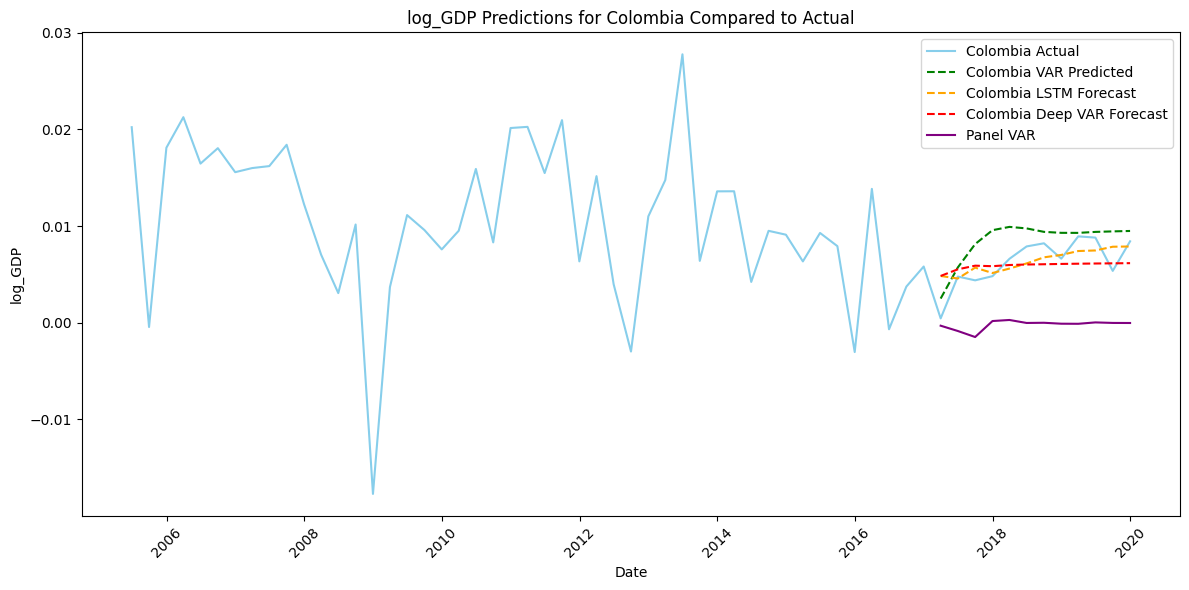

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


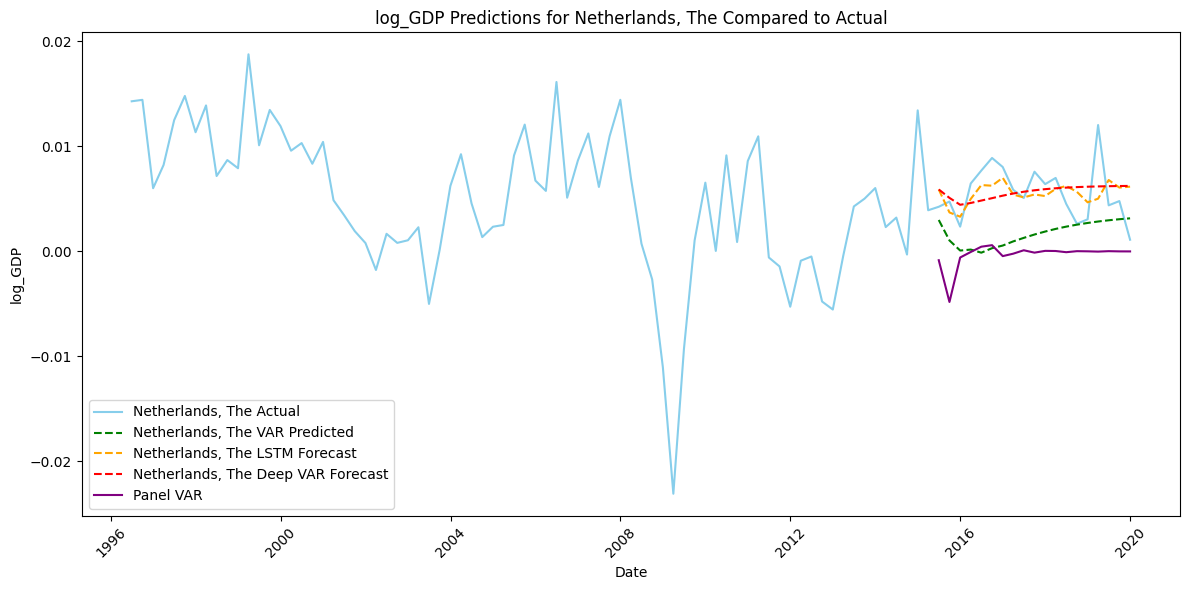

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


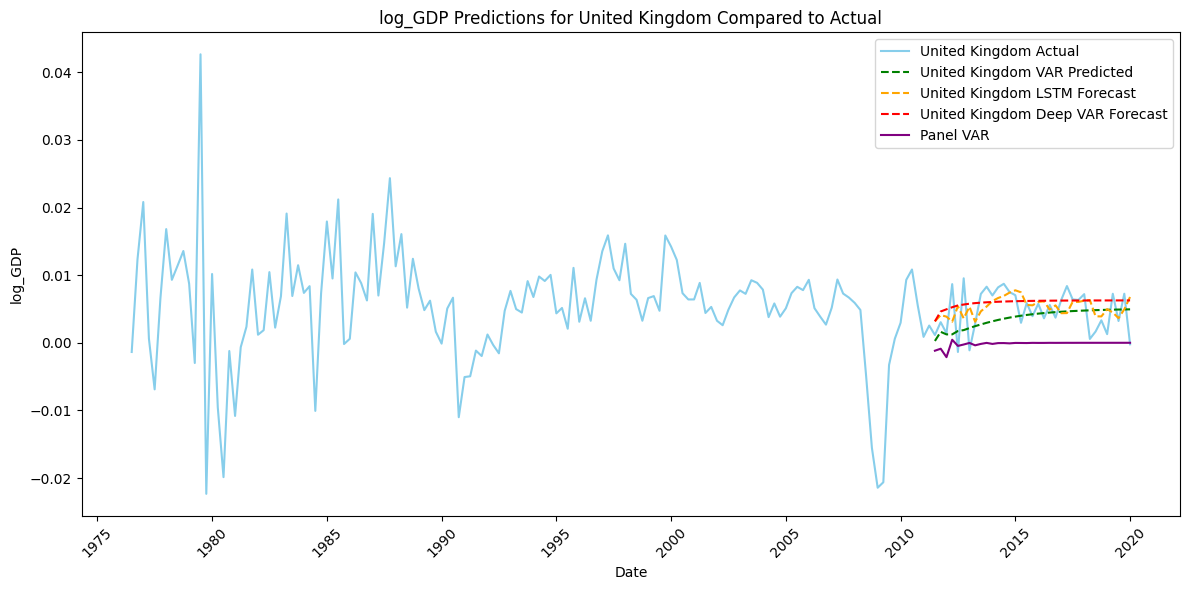

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


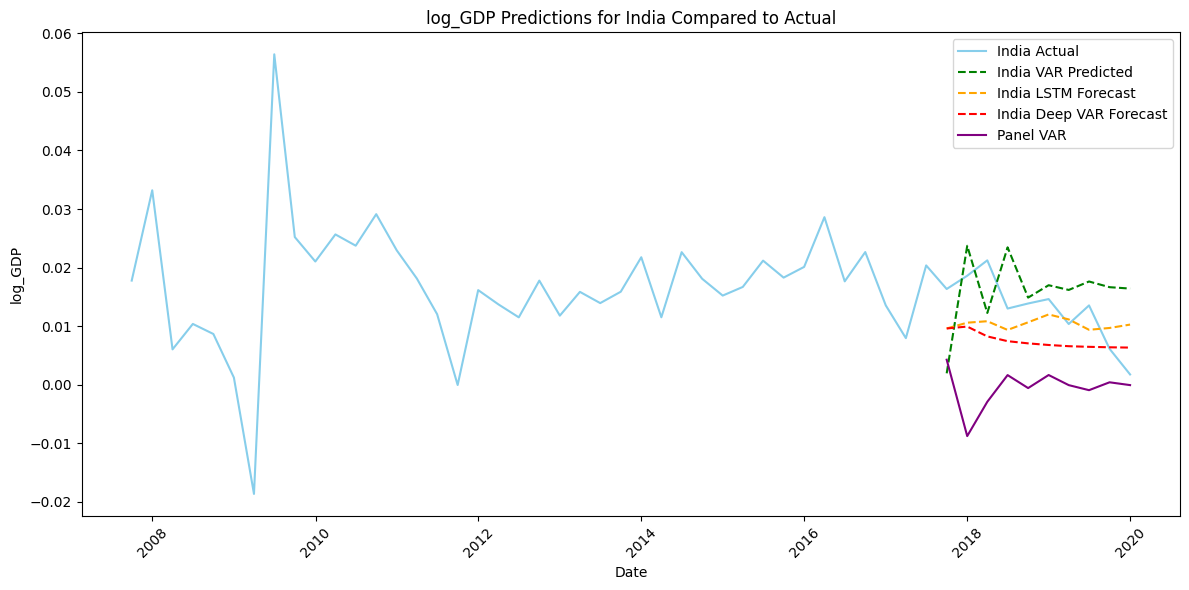

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


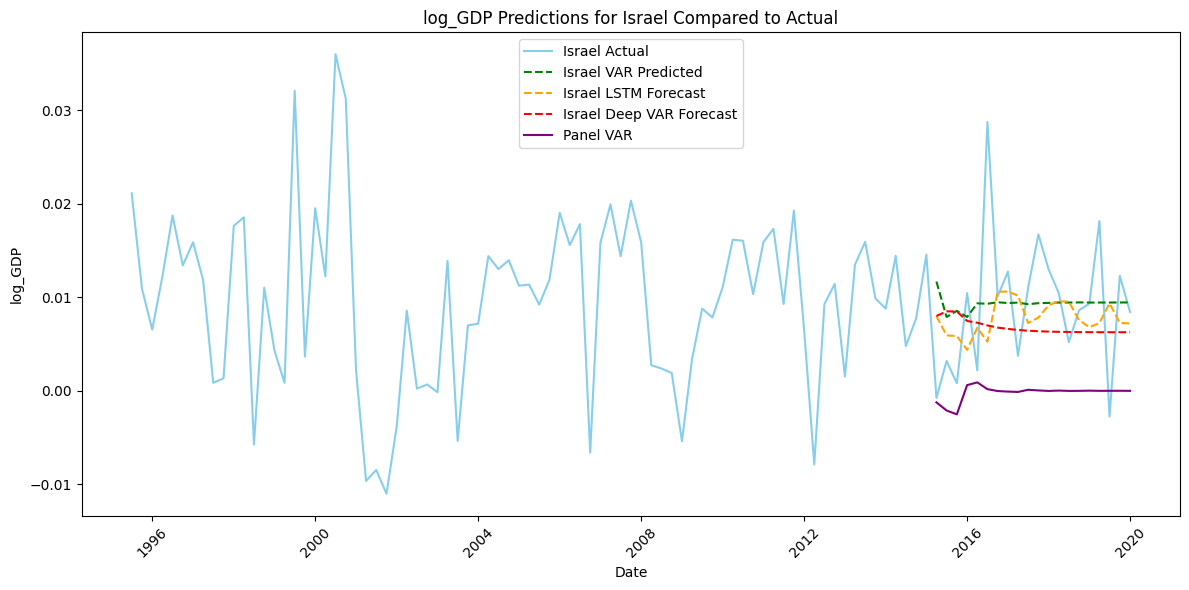

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


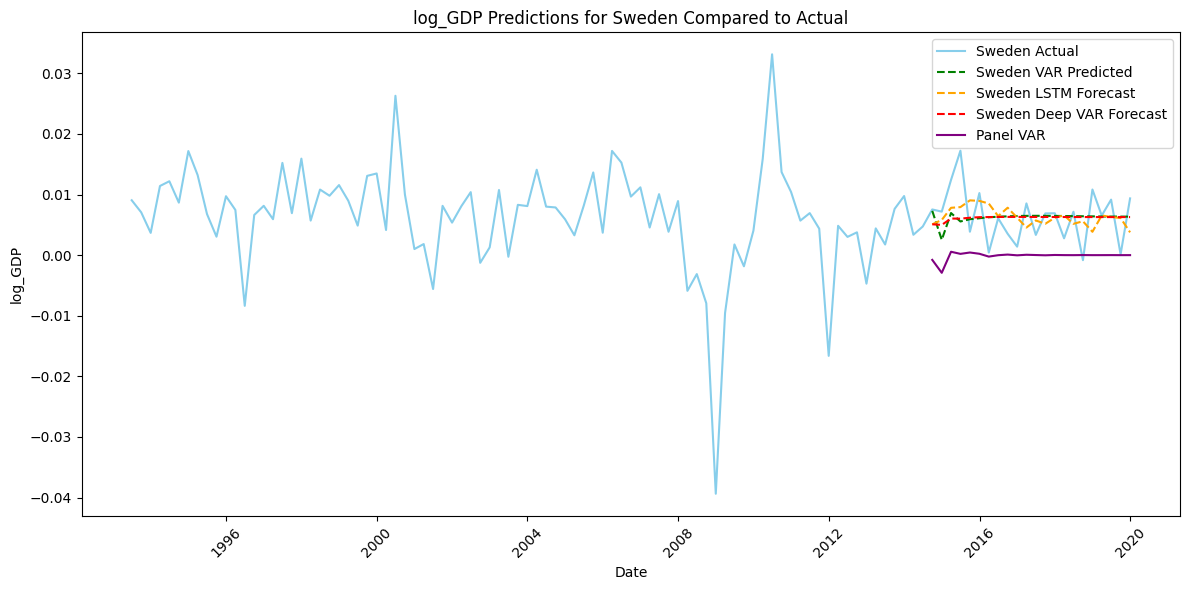

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


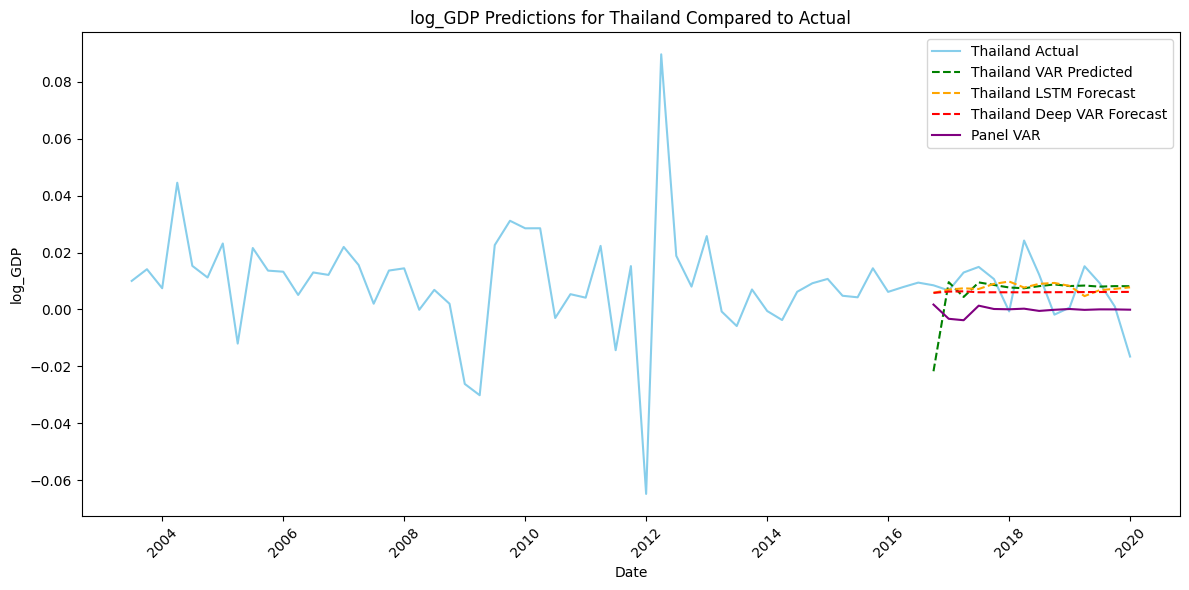

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


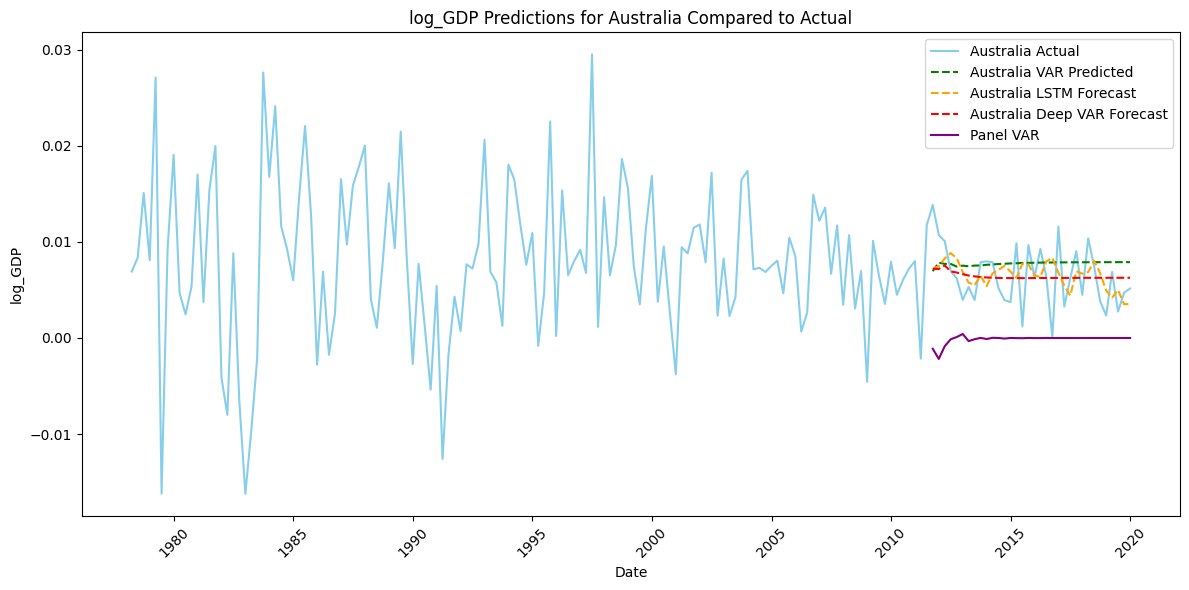

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


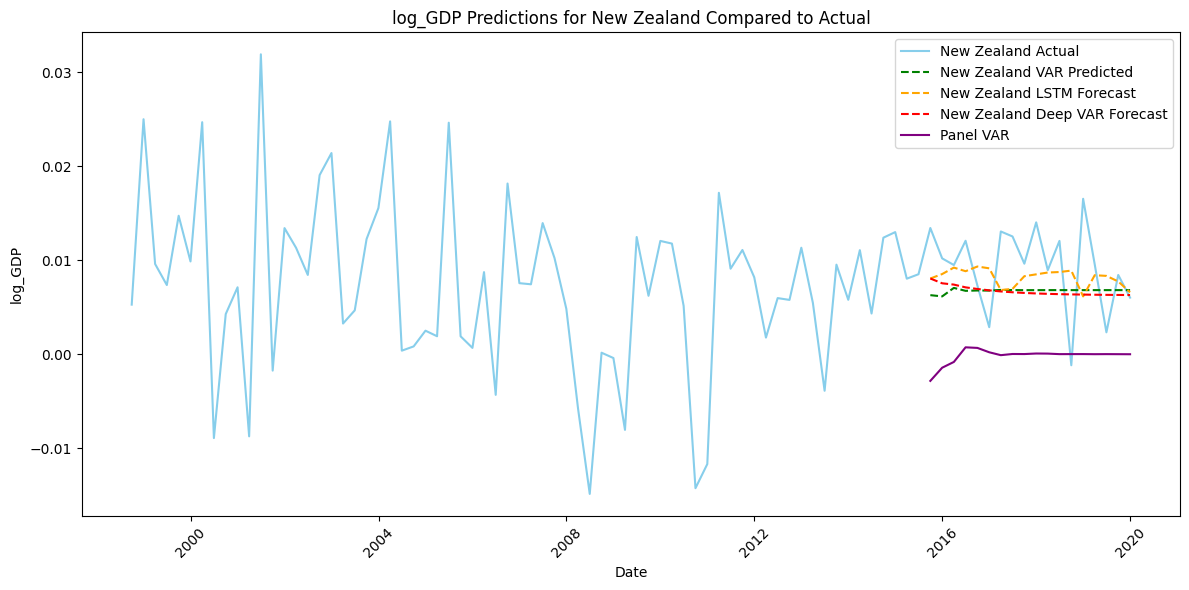

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


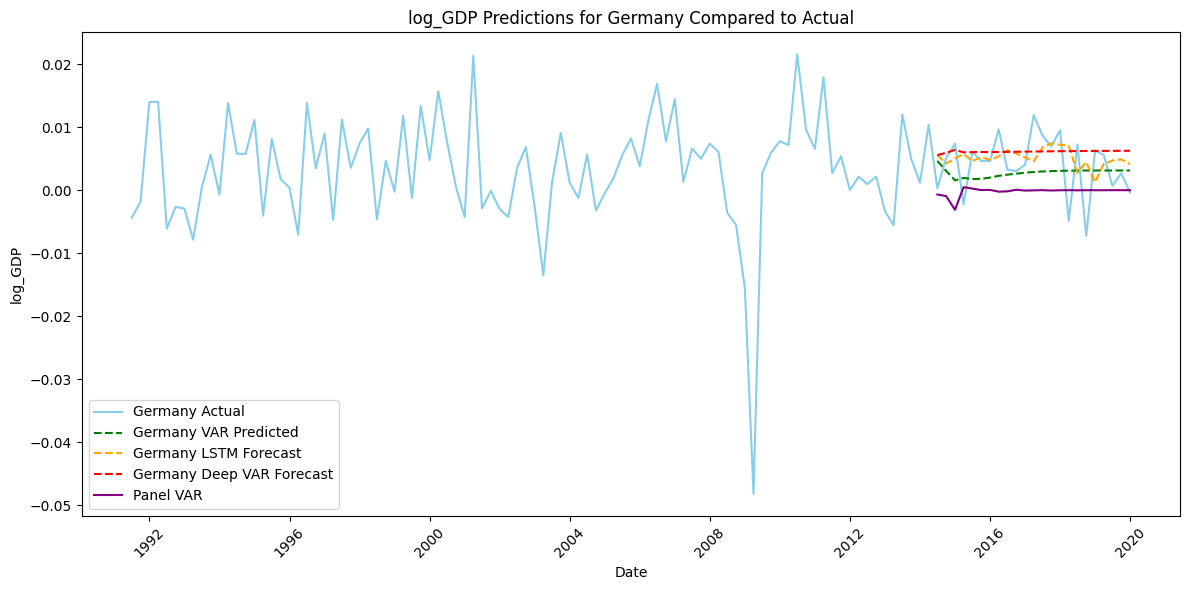

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


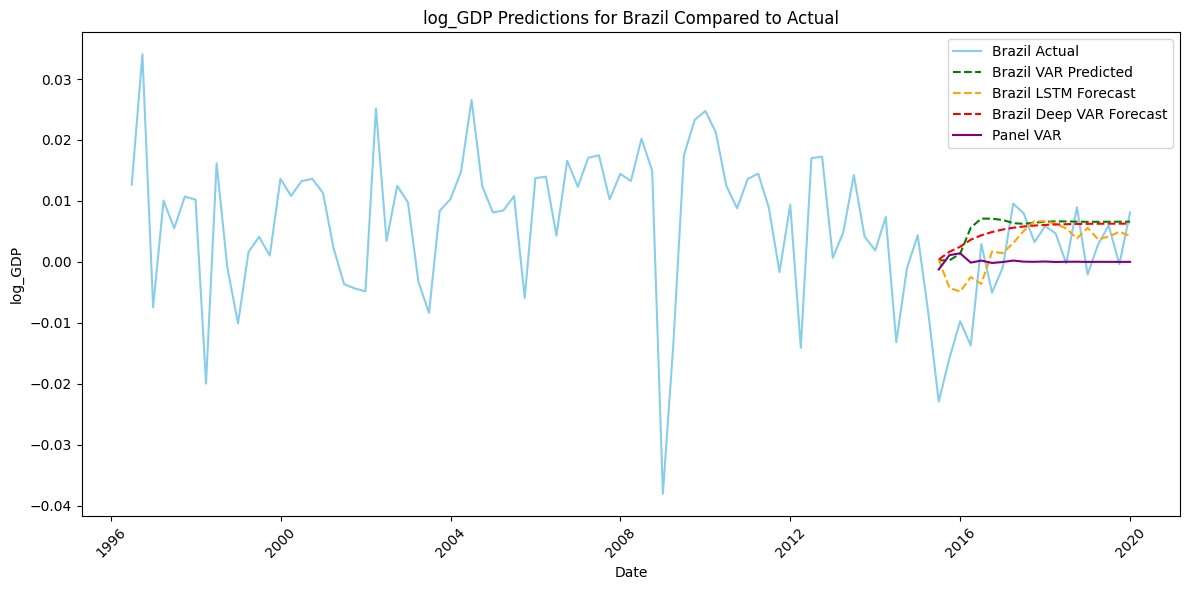

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


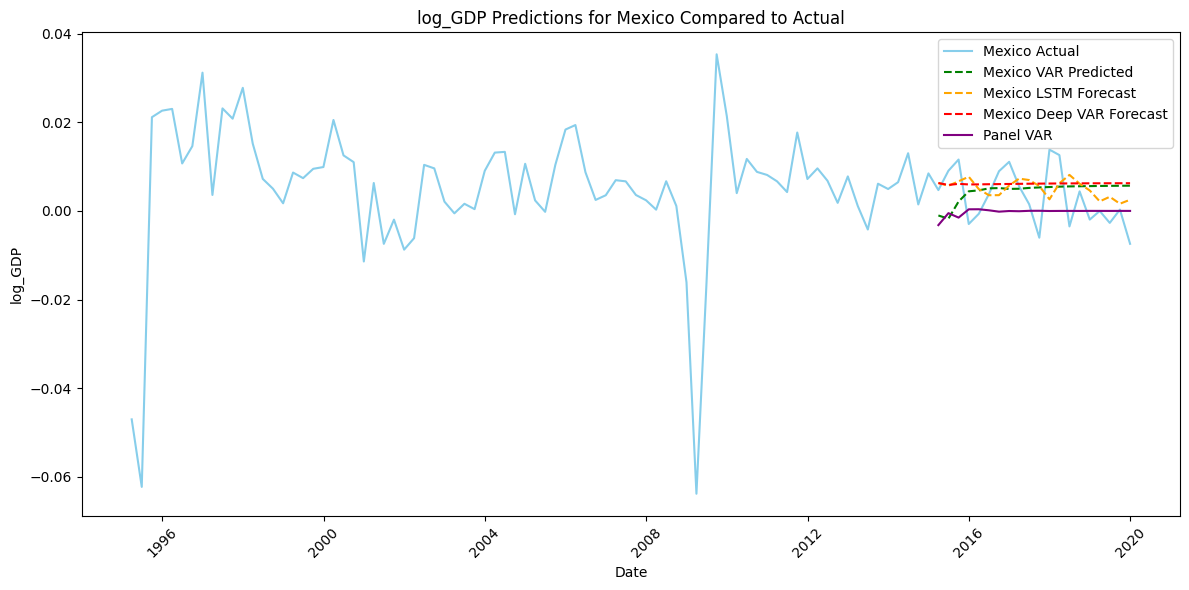

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


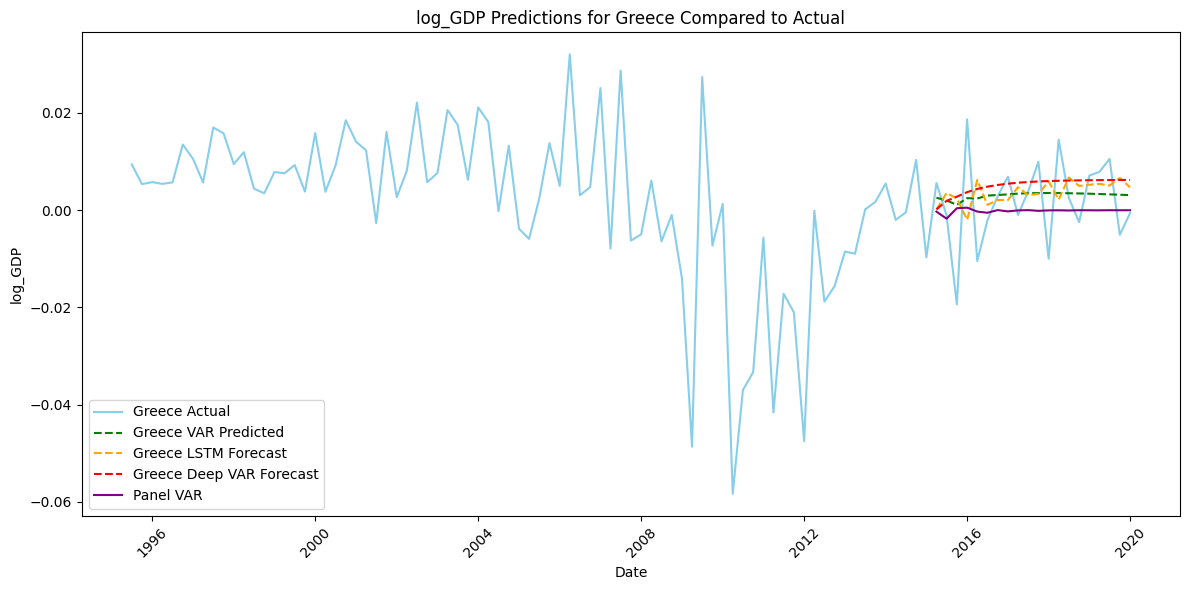

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


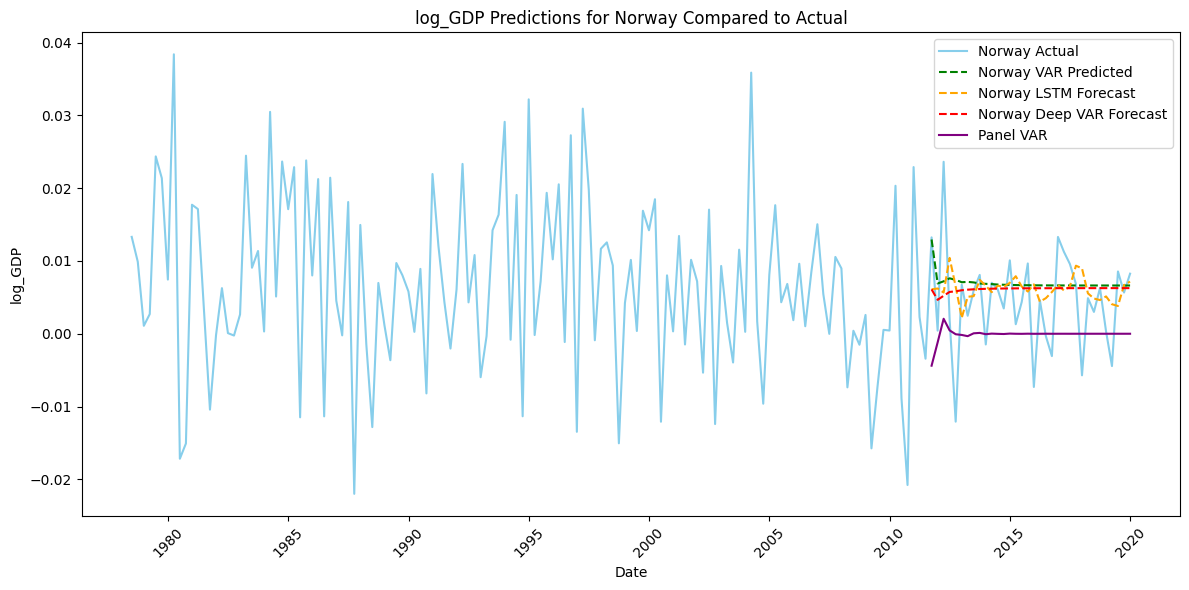

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


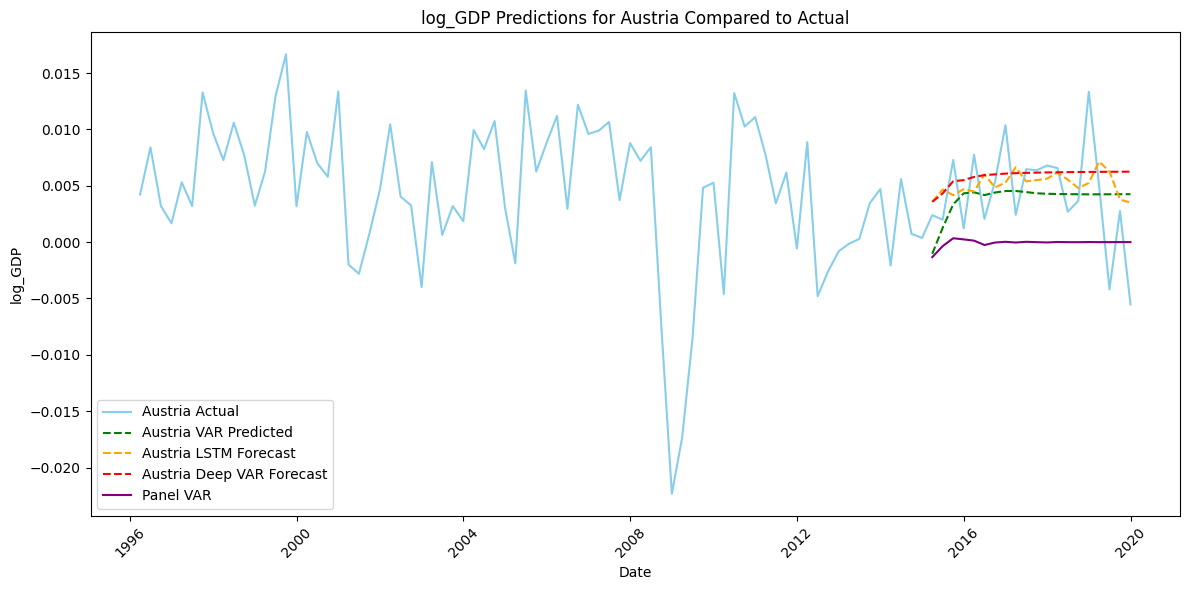

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


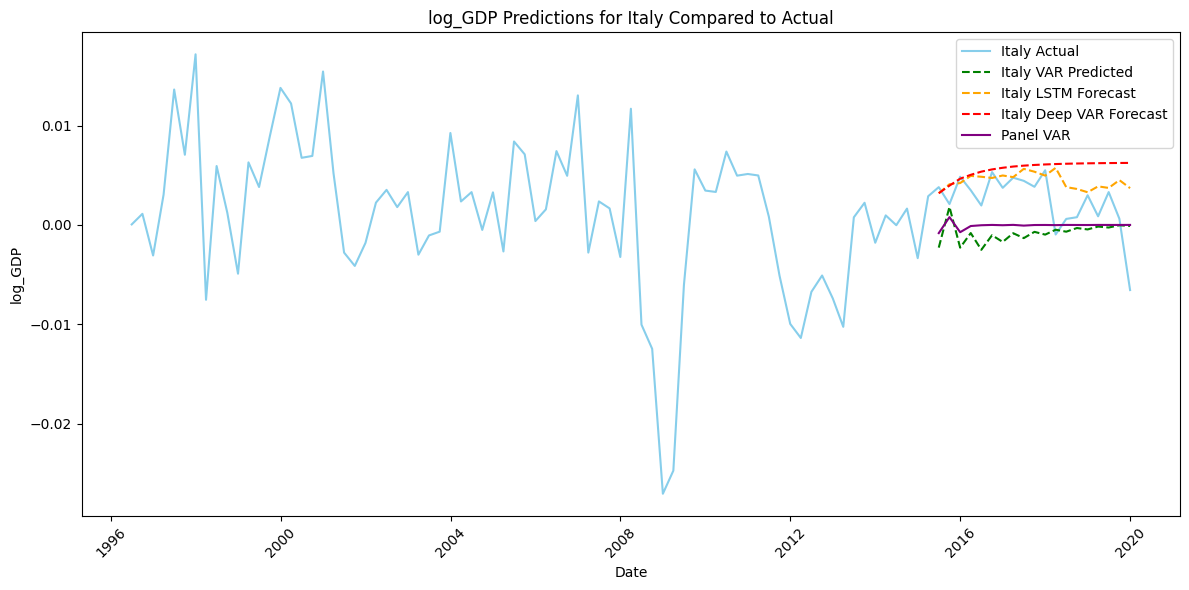

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


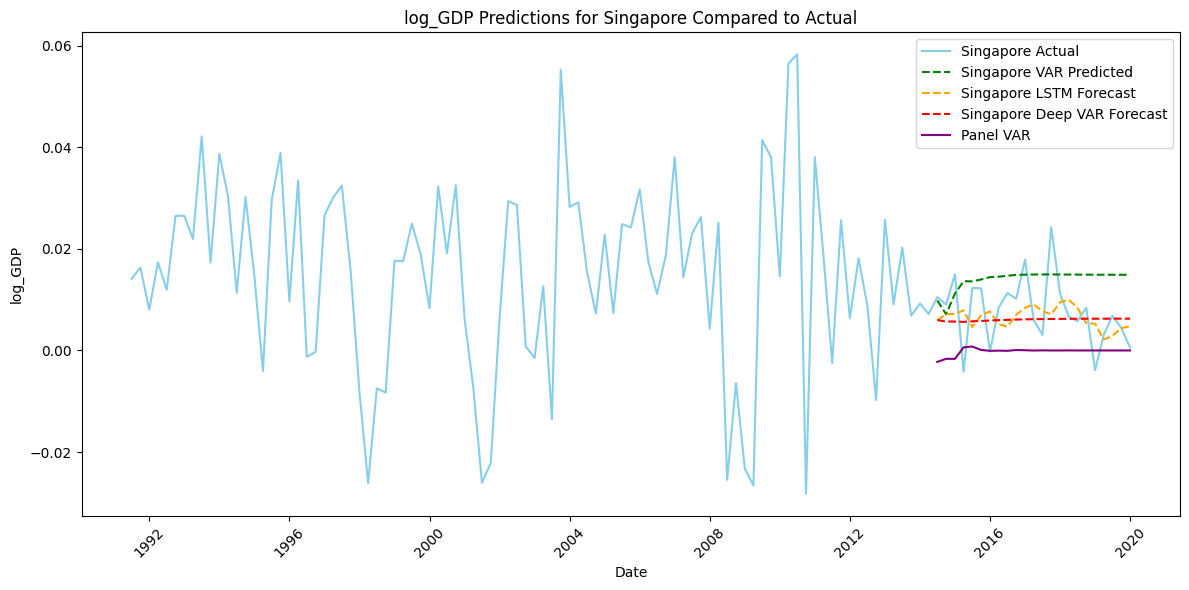

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


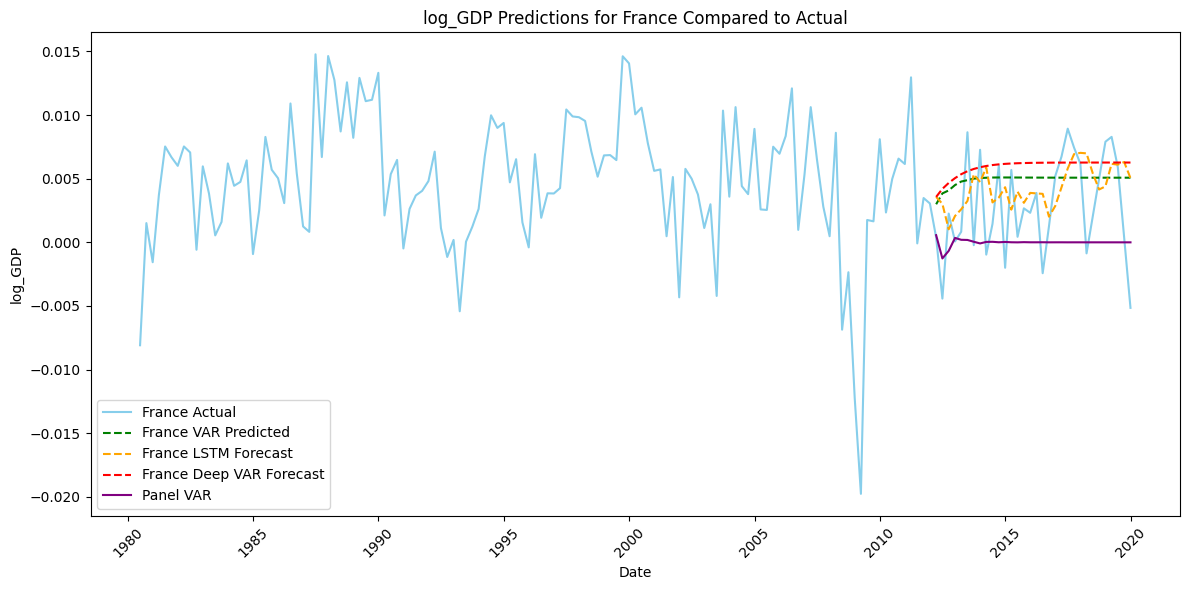

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


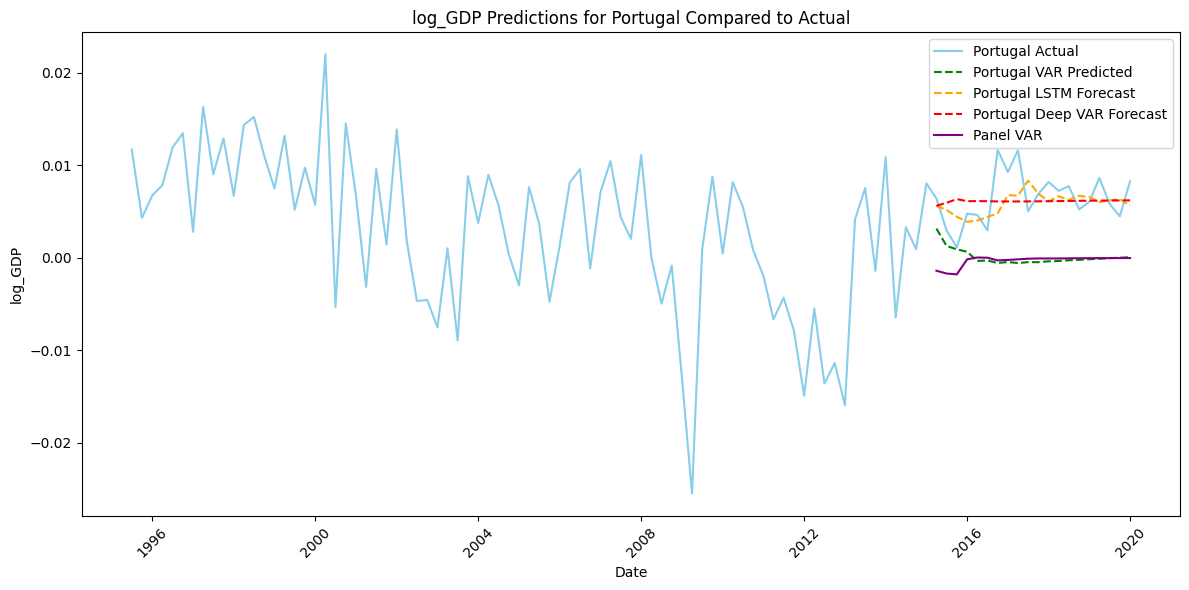

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


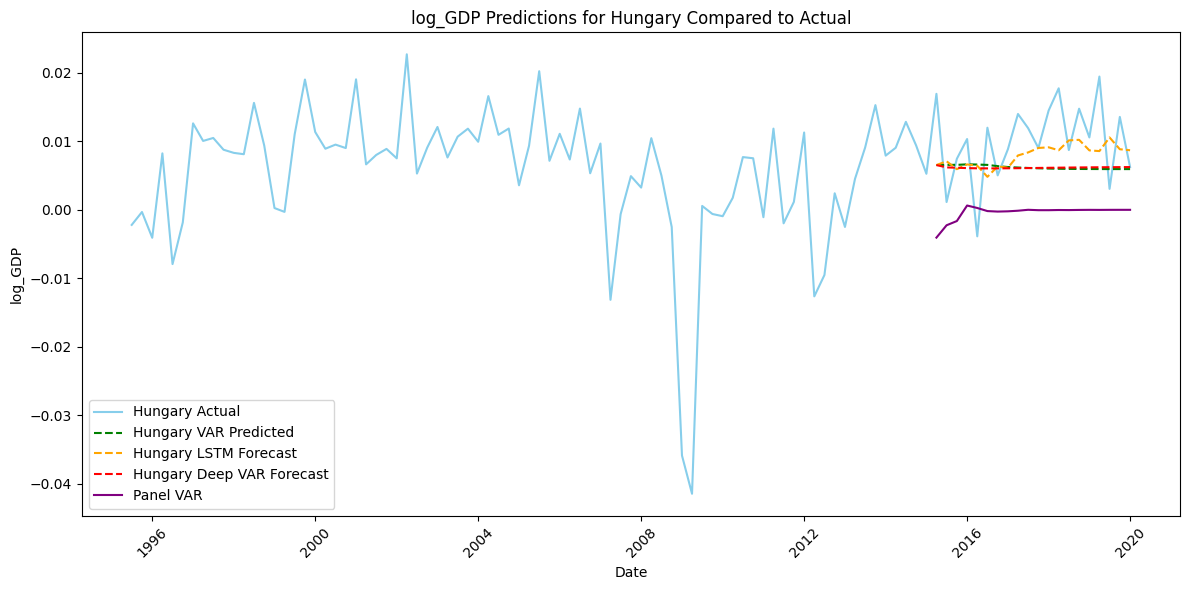

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


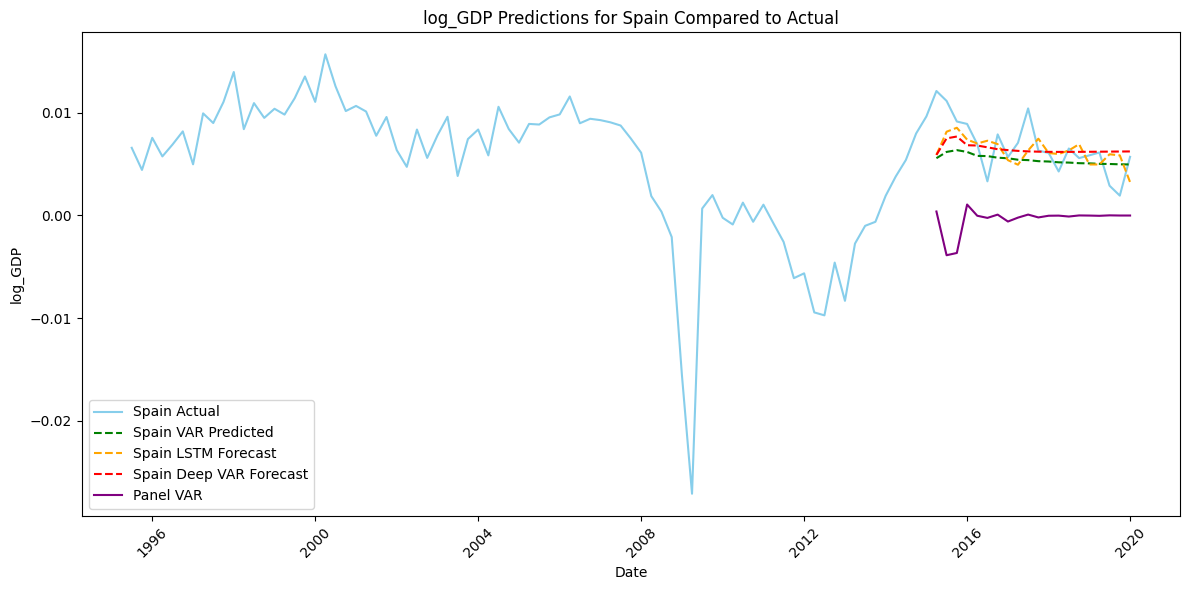

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


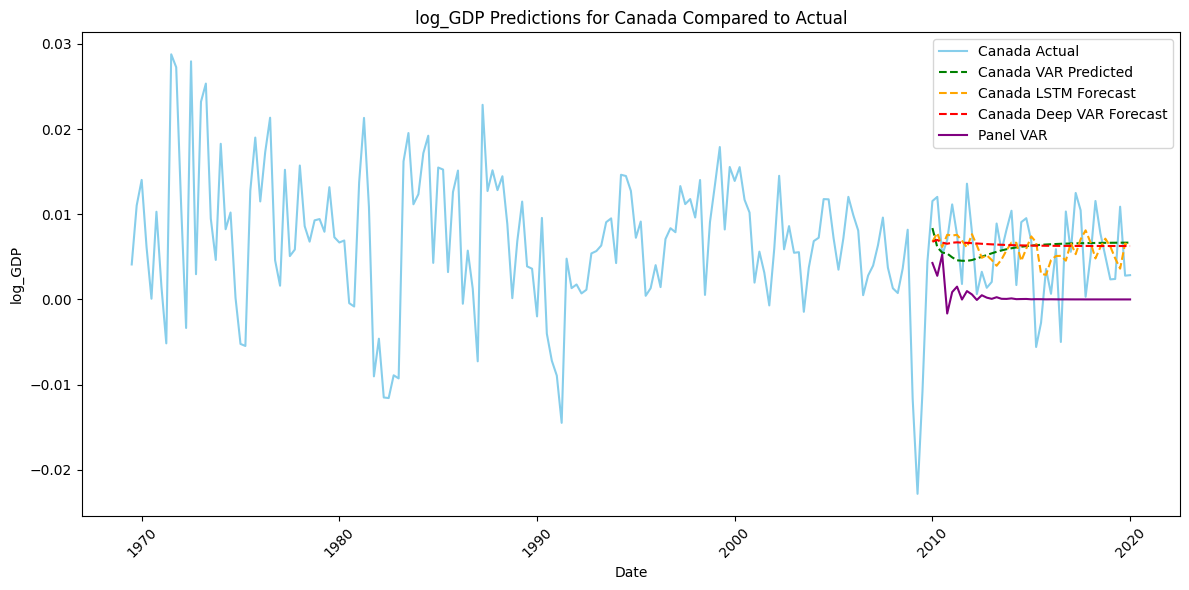

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


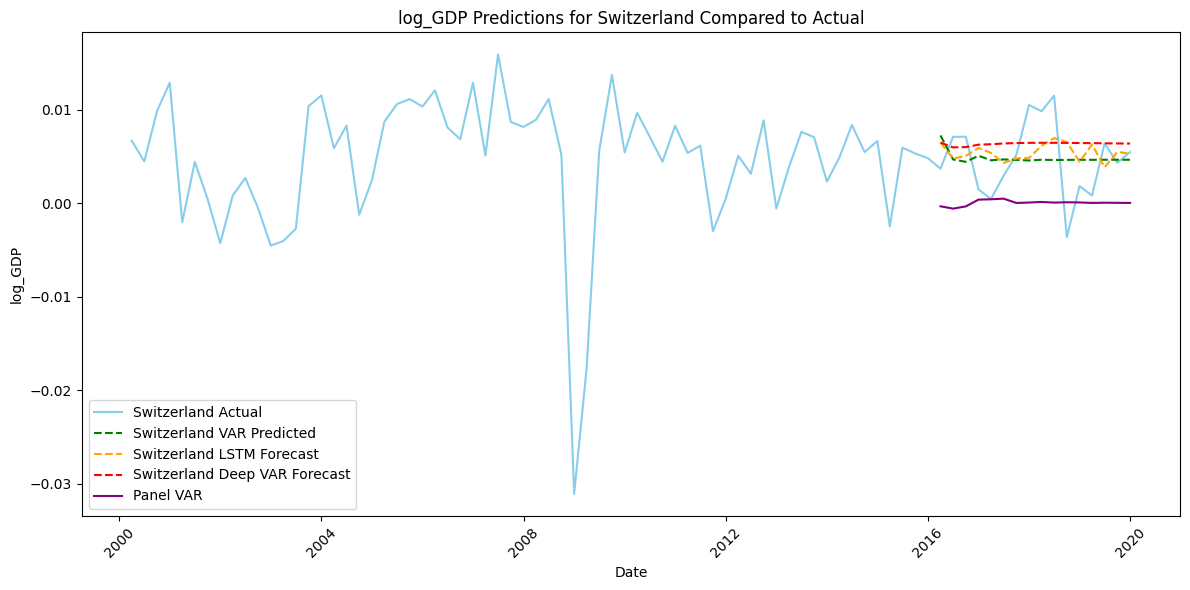

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


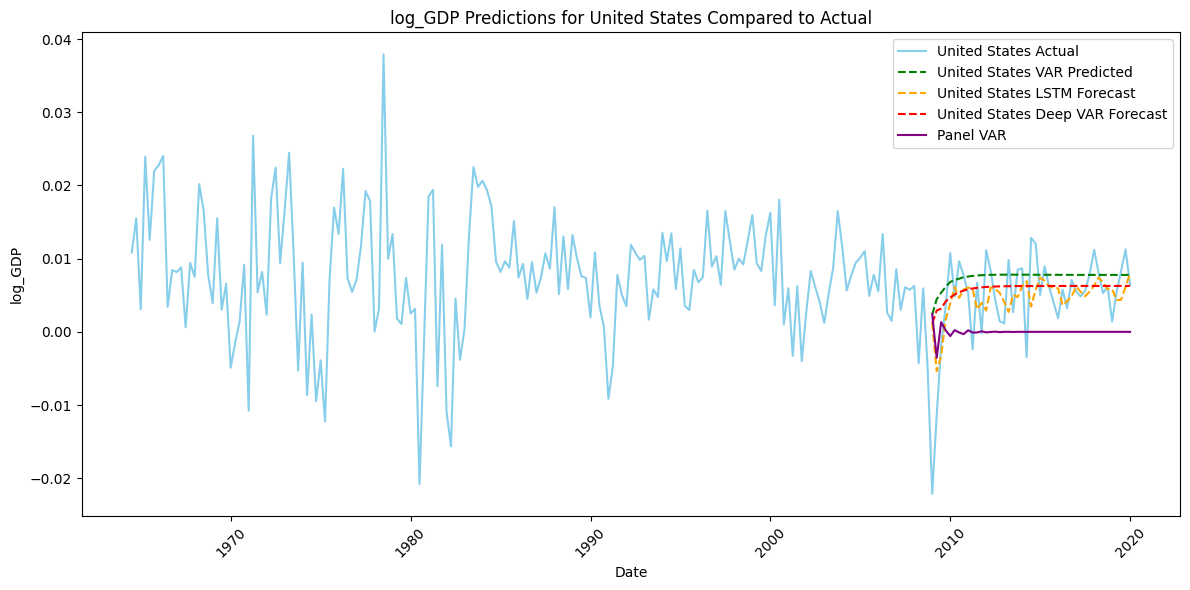

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


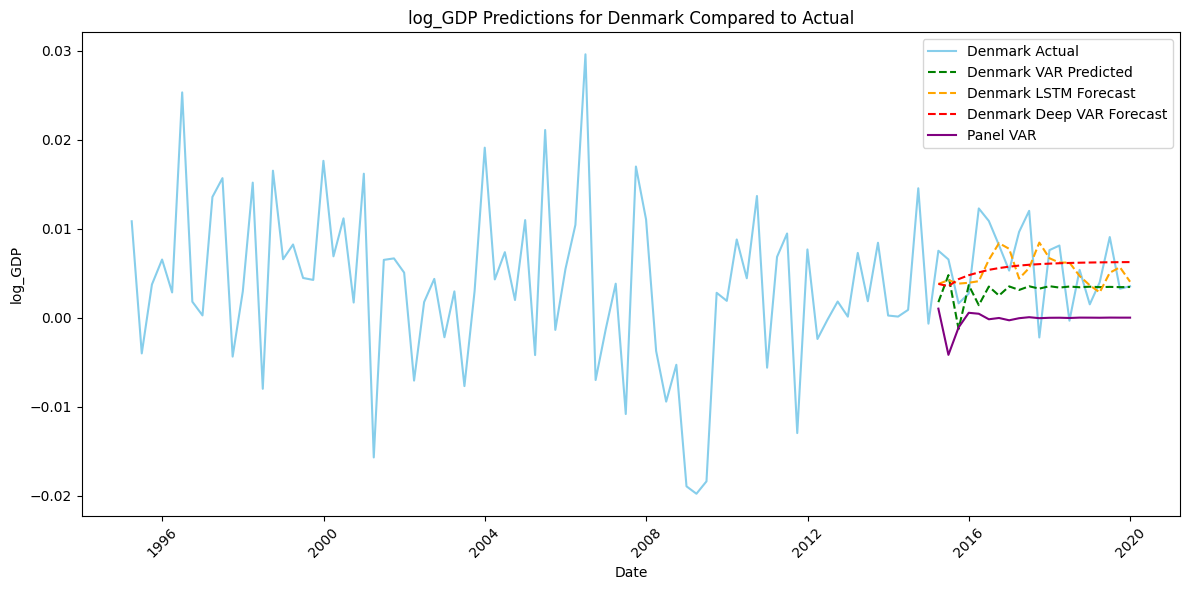

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


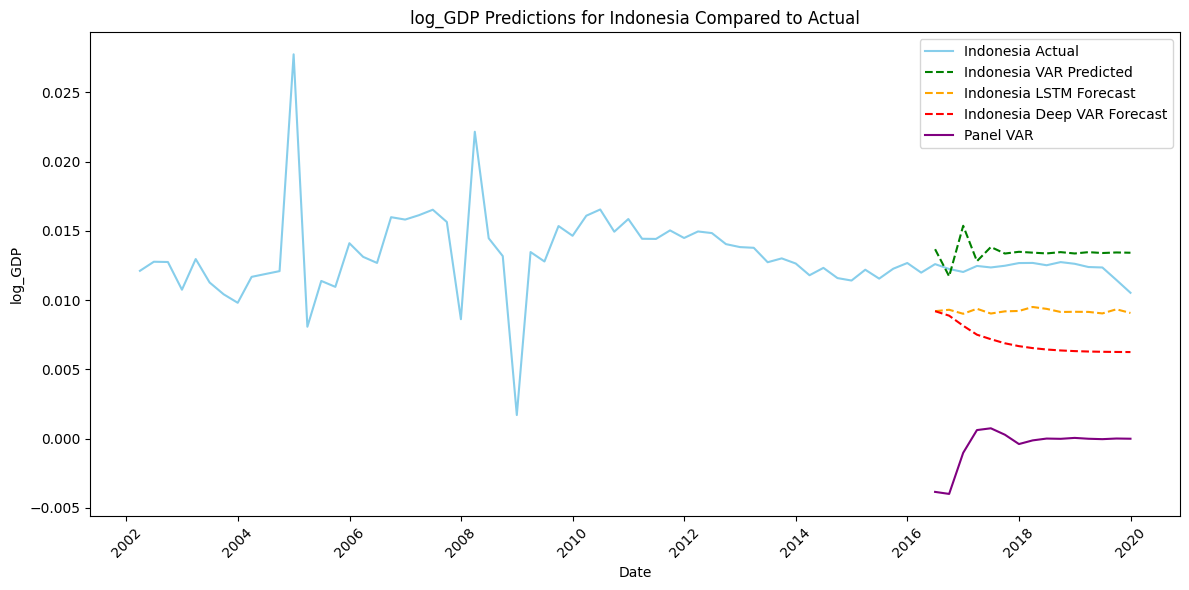

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


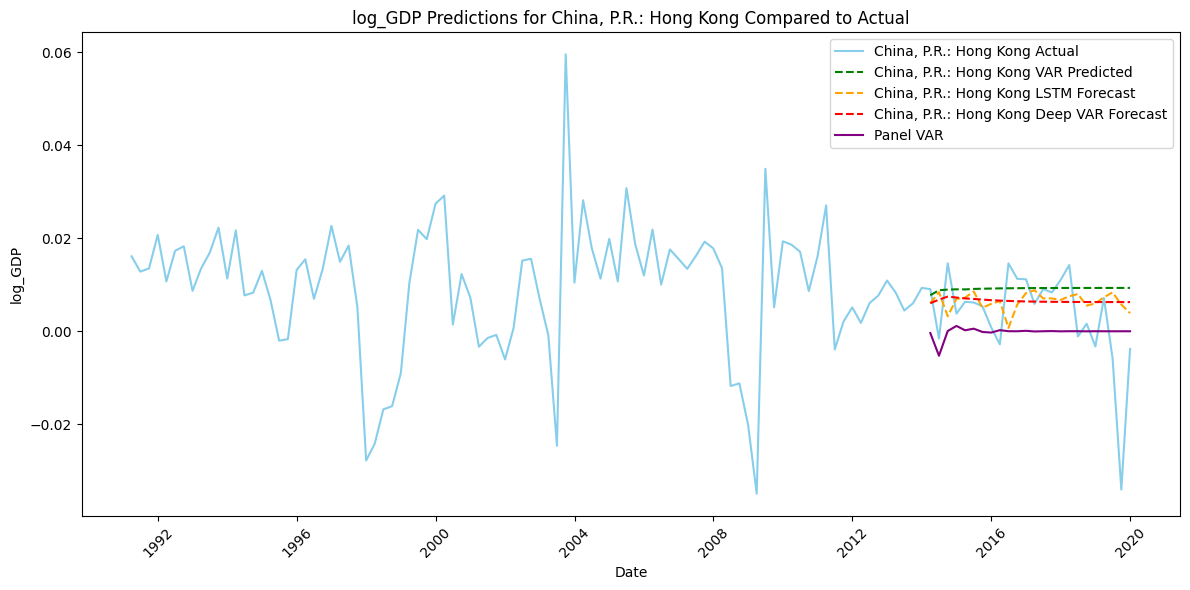

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


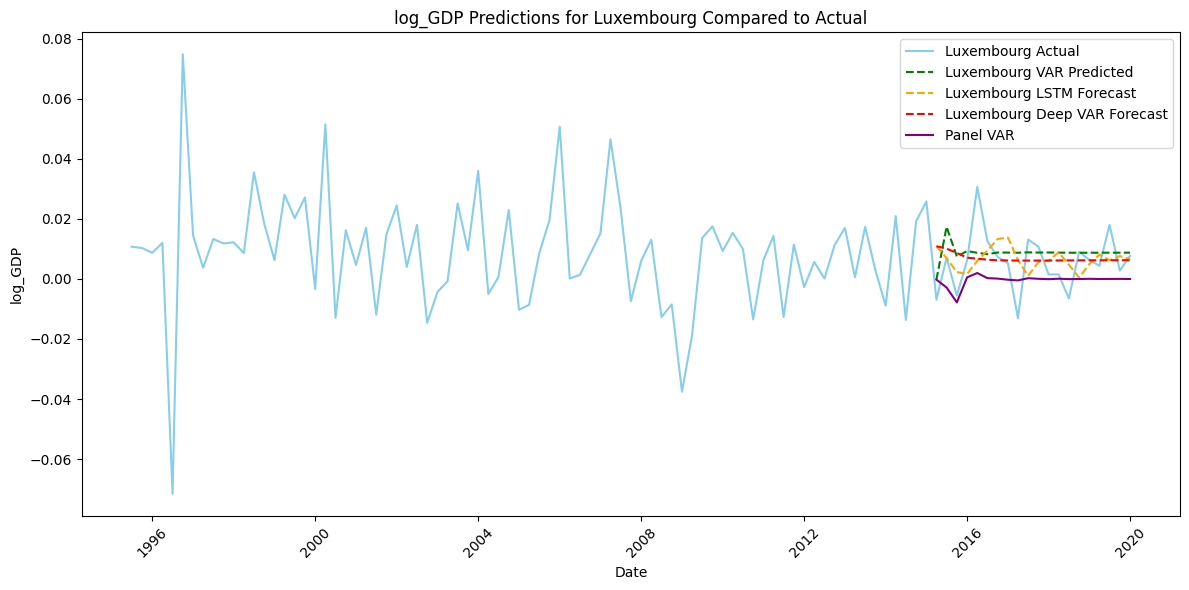

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


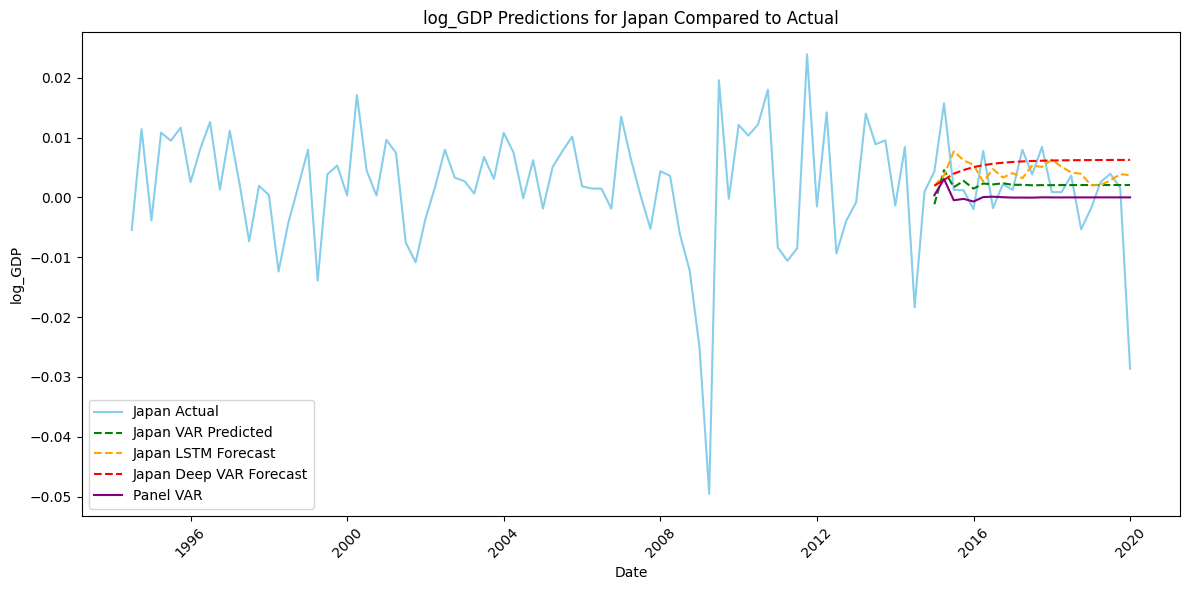

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


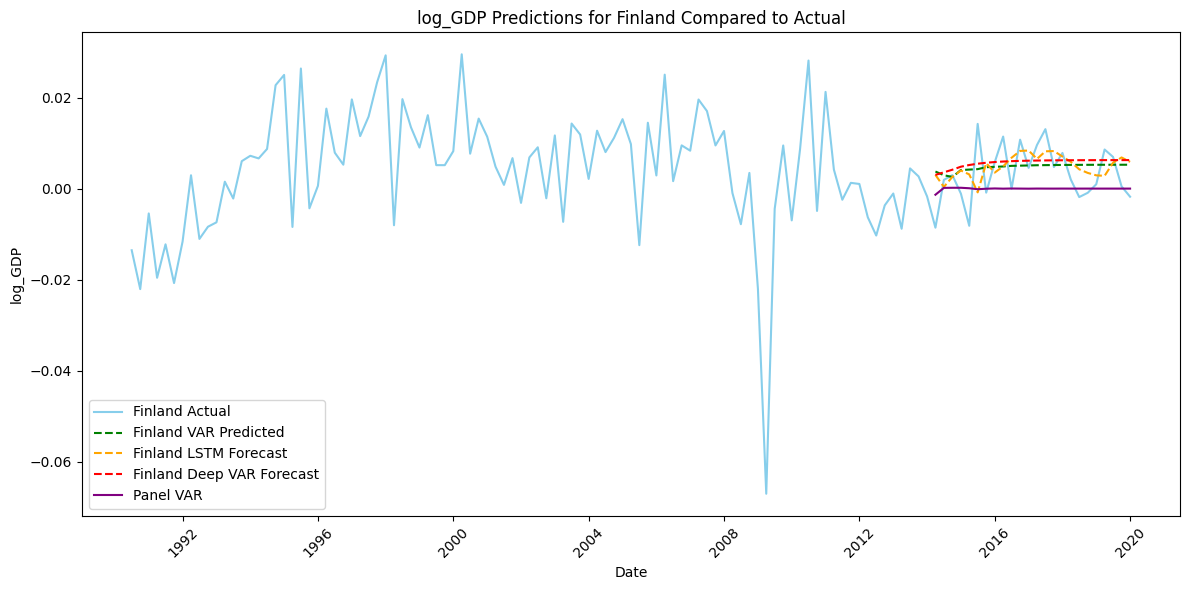

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


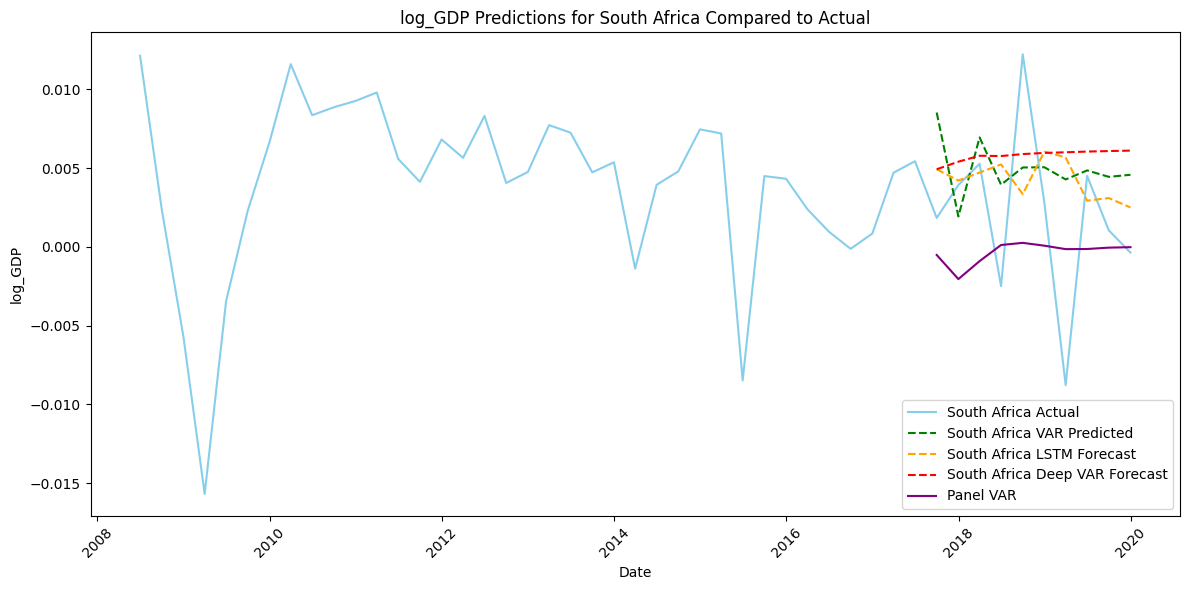

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


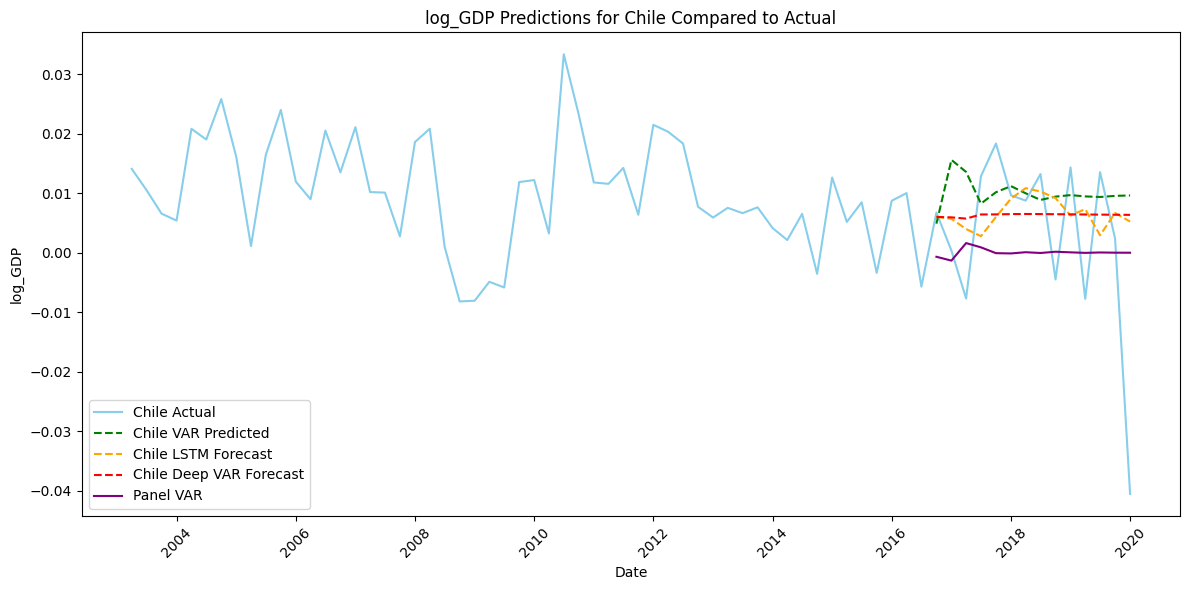

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


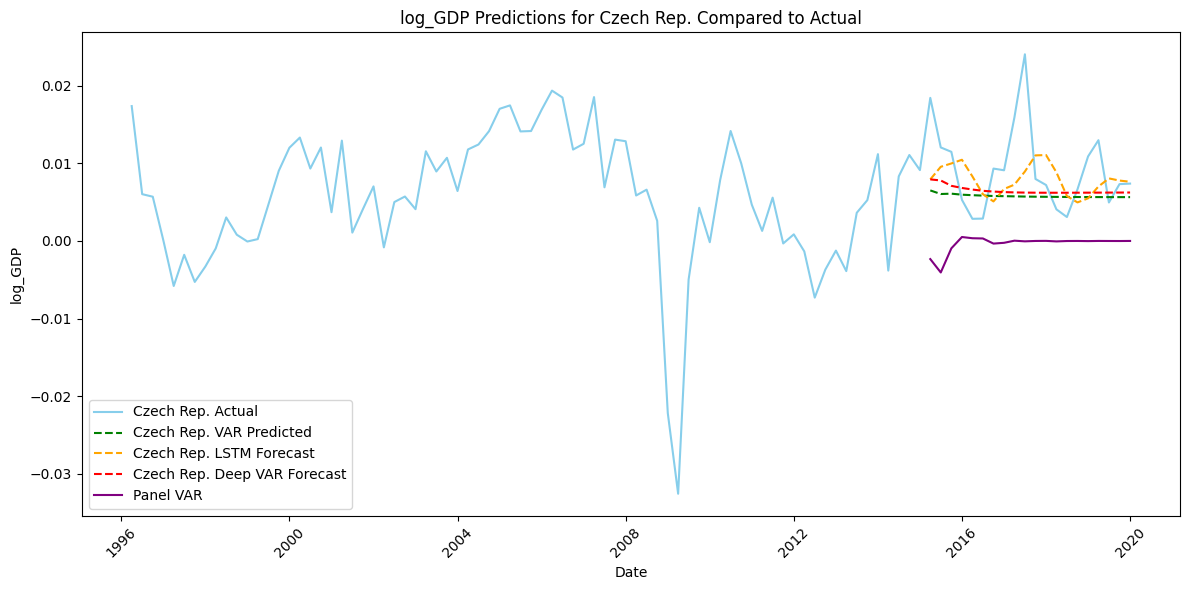

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


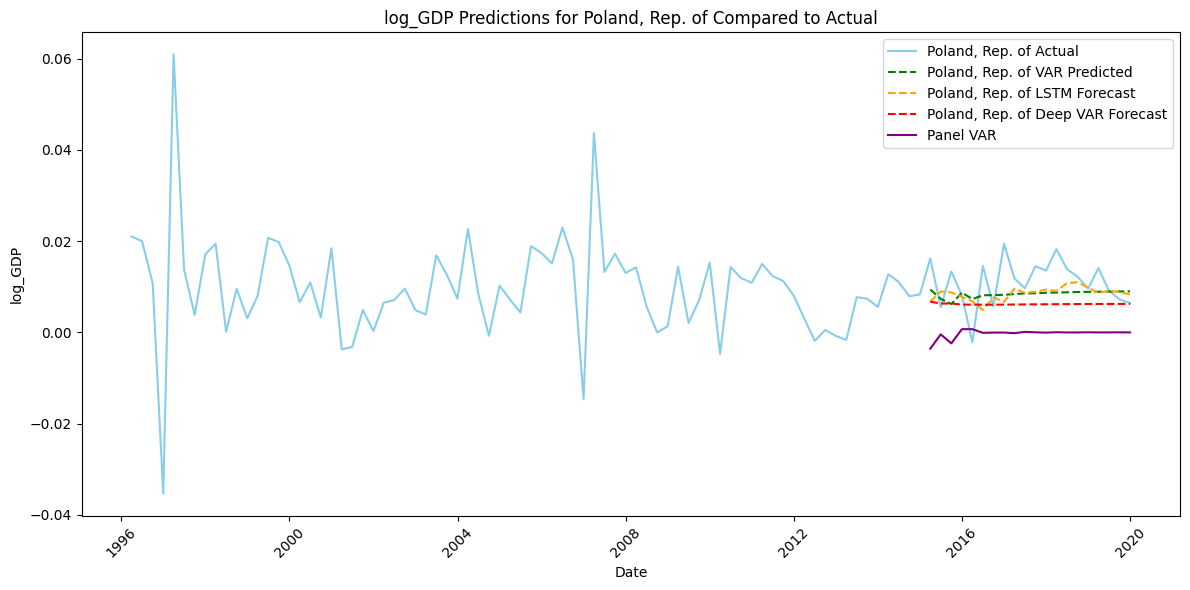

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


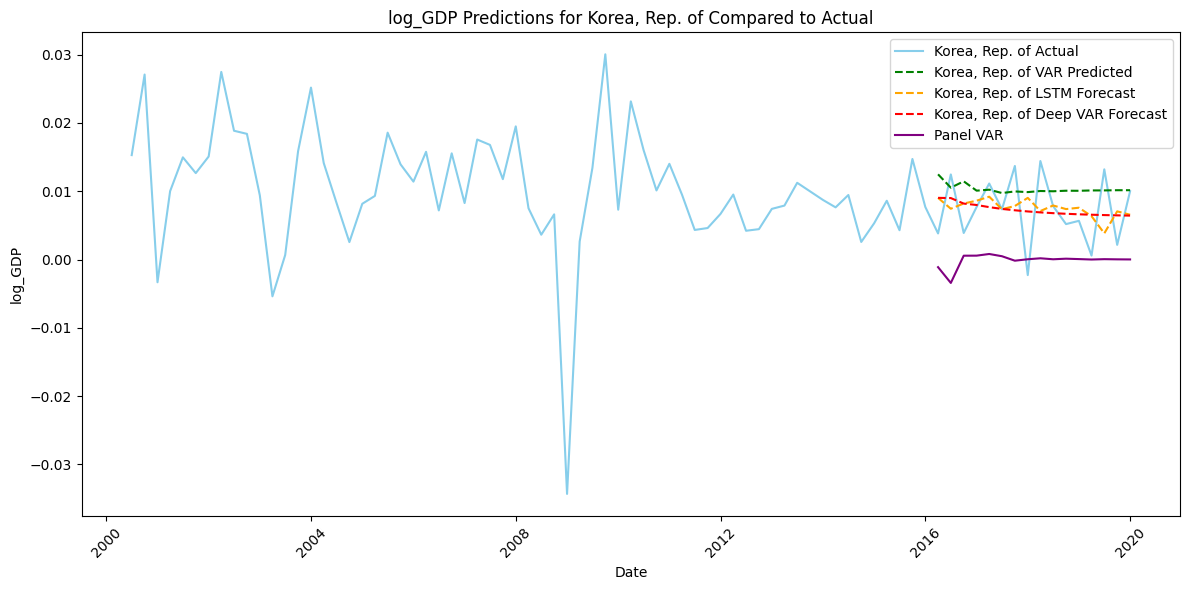

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


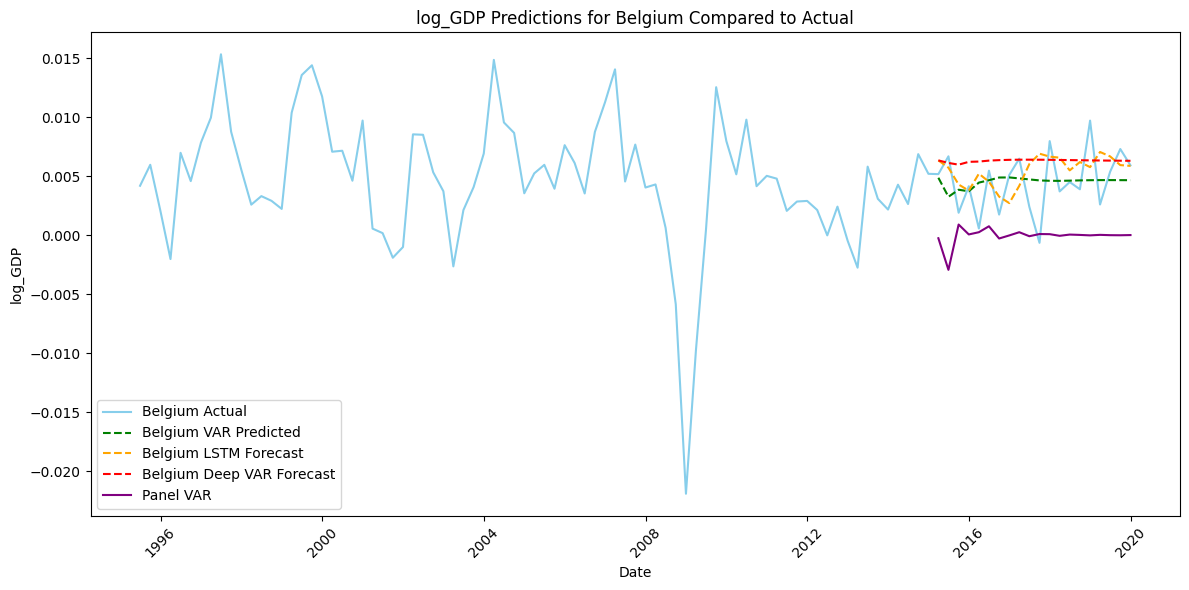

In [ ]:
countries = ['Colombia', 'Netherlands, The', 'United Kingdom', 'India', 'Israel',
       'Sweden', 'Thailand', 'Australia', 'New Zealand', 'Germany', 'Brazil',
       'Mexico', 'Greece', 'Norway', 'Austria', 'Italy', 'Singapore', 'France',
       'Portugal', 'Hungary', 'Spain', 'Canada', 'Switzerland',
       'United States', 'Denmark', 'Indonesia', 'China, P.R.: Hong Kong',
       'Luxembourg', 'Japan', 'Finland', 'South Africa', 'Chile', 'Czech Rep.',
       'Poland, Rep. of', 'Korea, Rep. of', 'Belgium']

inputsvar = final_detrend.columns

panel_var_coef = pd.read_excel('coef.xlsx', index_col=0)

for country in countries:
    pr.plot_country_predictions_test(
        country, 
        'log_GDP', 
        inputs, 
        LAGS, 
        lstm_df, 
        model_scaler_dict, 
        train_dt_var,
        test_dt_var, 
        final_detrend,
        panel_var_coef
    )

## Appendix


In [22]:
# Test to ensure that detrending is 
# plt.figure(figsize = (12,9))
# plt.plot(df[df['Country']=='Colombia'].index, test1['Household debt'], label = 'Test')
# plt.plot(df[df['Country']=='Colombia'].index, df[df['Country']=='Colombia']['Household debt'], label = 'Real', color = 'orange')
# plt.plot(df_detrended[df_detrended['Country']=='Norway'].index, df_detrended[df_detrended['Country']=='Norway']['log_GDP'], label = 'Real', color = 'skyblue')

In [23]:
# Testing the model on other data. 

# Look into how it is determining the outcomes. Look at techniques. What part of the data is it looking at. 

In [ ]:
final_detrend.describe()

summary_stats = df.describe().transpose()

latex_table = summary_stats.to_latex(float_format="%.5f")
print(latex_table)

\begin{tabular}{lrrrrrrrr}
\toprule
 & count & mean & std & min & 25% & 50% & 75% & max \\
\midrule
log_GDP & 4765.00000 & 13.11645 & 2.18978 & 8.65451 & 11.89587 & 12.85612 & 13.79808 & 20.16631 \\
household_debt & 4765.00000 & 53.88753 & 29.39850 & 1.80000 & 34.00000 & 51.10000 & 69.70000 & 136.80000 \\
private_debt & 4765.00000 & 88.17279 & 51.59001 & 12.30000 & 56.20000 & 79.60000 & 107.70000 & 370.10000 \\
\bottomrule
\end{tabular}



In [25]:
num_variables_deepvar = len(inputs)
df_zeros = pd.DataFrame(np.zeros((1, num_variables_deepvar)), columns=inputs)


In [26]:
print(inputs)

# -3.50000 & -0.20000 & 0.20000 & 0.70000 & 4.40000

['log_GDP_lag1', 'log_GDP_lag2', 'log_GDP_lag3', 'household_debt_lag1', 'household_debt_lag2', 'household_debt_lag3', 'private_debt_lag1', 'private_debt_lag2', 'private_debt_lag3']


Small Change in Household debt % change effect on GDP

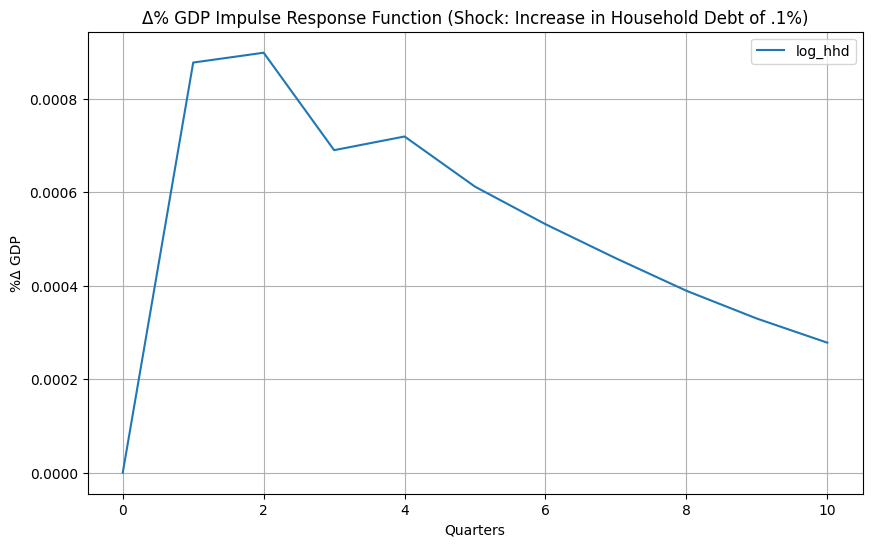

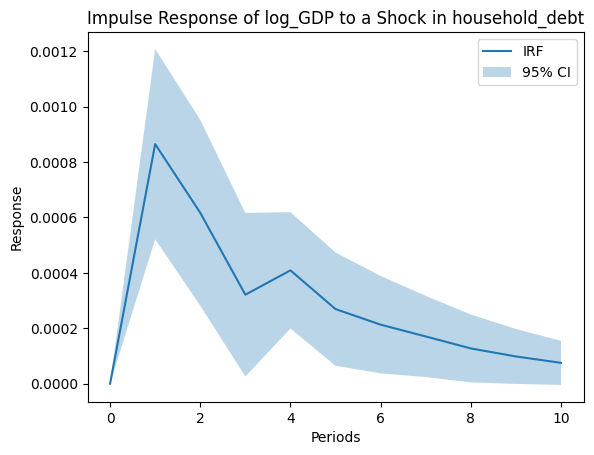

[[[ 7.00000000e-01  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  7.00000000e-01  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  7.00000000e-01]]

 [[ 1.35558126e-01  8.64833624e-04 -1.78358569e-05]
  [-2.16876764e+00  2.34854532e-01  5.52017533e-04]
  [-5.40121600e+00  1.13351717e-01  2.00960646e-01]]

 [[ 1.38111749e-01  6.16894877e-04 -1.14148453e-04]
  [-3.94476383e+00  2.63218238e-01 -1.00050876e-03]
  [ 8.28249387e-01  9.10912788e-02  1.55436441e-01]]

 [[ 1.13322680e-01  3.21259819e-04 -1.23316476e-04]
  [-2.79199960e+00  1.83925079e-01 -2.75326716e-03]
  [-4.07997407e+00  1.12164681e-01  5.00119920e-02]]

 [[ 5.49066236e-02  4.09121118e-04 -9.10395140e-05]
  [-2.98244336e+00  1.41003680e-01 -1.37452494e-03]
  [-2.15444236e+00  8.51151025e-02  2.92659185e-02]]

 [[ 4.07241939e-02  2.69329044e-04 -7.32083719e-05]
  [-2.56840744e+00  1.07880476e-01 -1.16746687e-03]
  [-2.21763194e+00  7.03621855e-02  1.02960973e-02]]

 [[ 2.61103177e-02  2.13144205e-04 -5.09795672e-05]


In [ ]:
plot1_irf_results = irf.predict(df_zeros, inputs, 'household_debt_lag1', .7, 'log_GDP', 10, model_scaler_dict)
plot1_title = 'Δ% GDP Impulse Response Function (Shock: Increase in Household Debt of .1%)'
plot1_var = '%Δ GDP'
irf.plot(plot1_irf_results, 'log_hhd', plot1_title, plot1_var)

from statsmodels.tsa.api import VAR
shock_size = 0.7

test2 = VAR(final_detrend)
test2_results = test2.fit(maxlags=3)
var_irf = test2_results.irf(10)

scaled_irf = var_irf.irfs * shock_size
scaled_stderr = var_irf.stderr(orth=False) * shock_size  

response_index = test2_results.names.index('household_debt')
impulse_index = test2_results.names.index('log_GDP')

irf_values = scaled_irf[:, impulse_index, response_index]
irf_stderr = scaled_stderr[:, impulse_index, response_index]

alpha = 0.05
z_score = 1.96  
lower_ci = irf_values - z_score * irf_stderr
upper_ci = irf_values + z_score * irf_stderr

plt.plot(irf_values, label='IRF')
plt.fill_between(range(len(irf_values)), lower_ci, upper_ci, alpha=0.3, label='95% CI')
plt.title('Impulse Response of log_GDP to a Shock in household_debt')
plt.xlabel('Periods')
plt.ylabel('Response')
plt.legend()
plt.show()
print(scaled_irf)

Average Change in Household debt % change effect on GDP

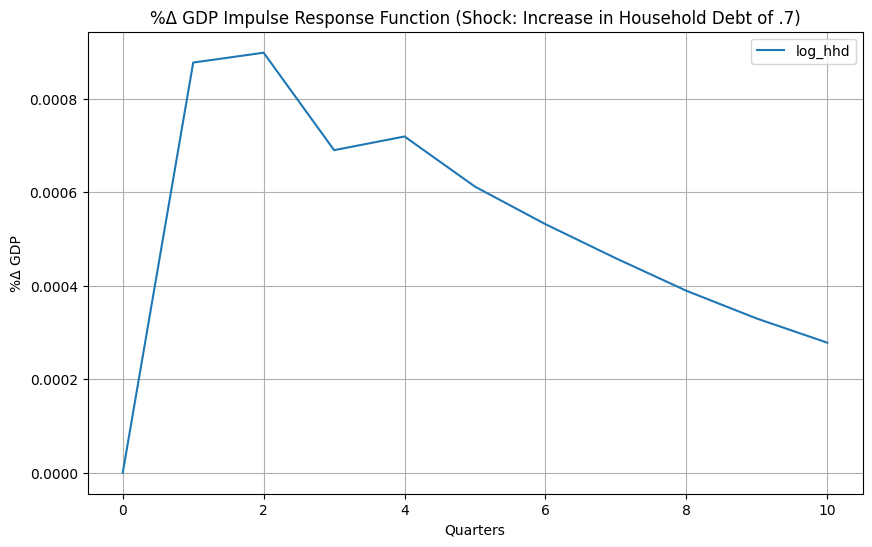

In [ ]:
plot2_irf_results = irf.predict(df_zeros, inputs, 'household_debt_lag1', 0.70000, 'log_GDP', 10, model_scaler_dict)
plot2_title = '%Δ GDP Impulse Response Function (Shock: Increase in Household Debt of .7)'
plot2_var = '%Δ GDP'
irf.plot(plot2_irf_results, 'log_hhd', plot2_title, plot2_var)

Large Change in Household debt % change effect on GDP

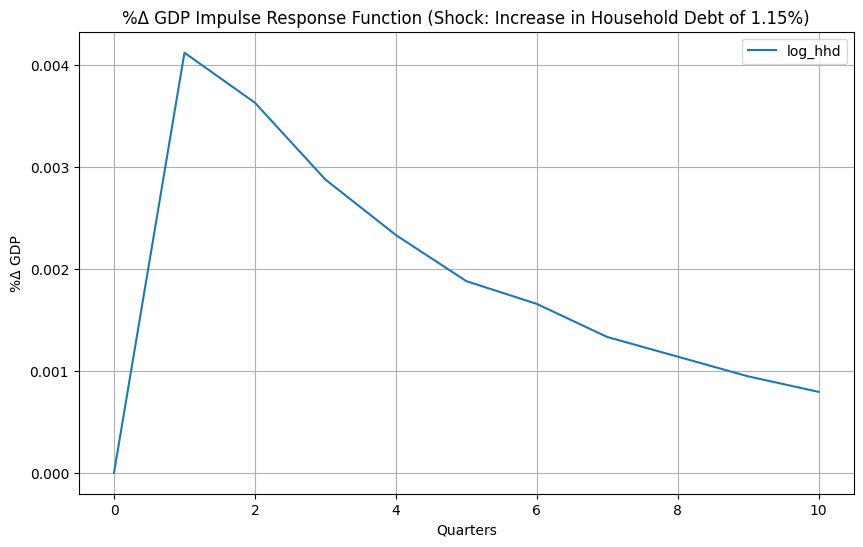

In [ ]:
plot3_irf_results = irf.predict(df_zeros, inputs, 'household_debt_lag1', 4.4, 'log_GDP', 10, model_scaler_dict)
plot3_title = '%Δ GDP Impulse Response Function (Shock: Increase in Household Debt of 1.15%)'
plot3_var = '%Δ GDP'

irf.plot(plot3_irf_results, 'log_hhd', plot3_title, plot3_var)

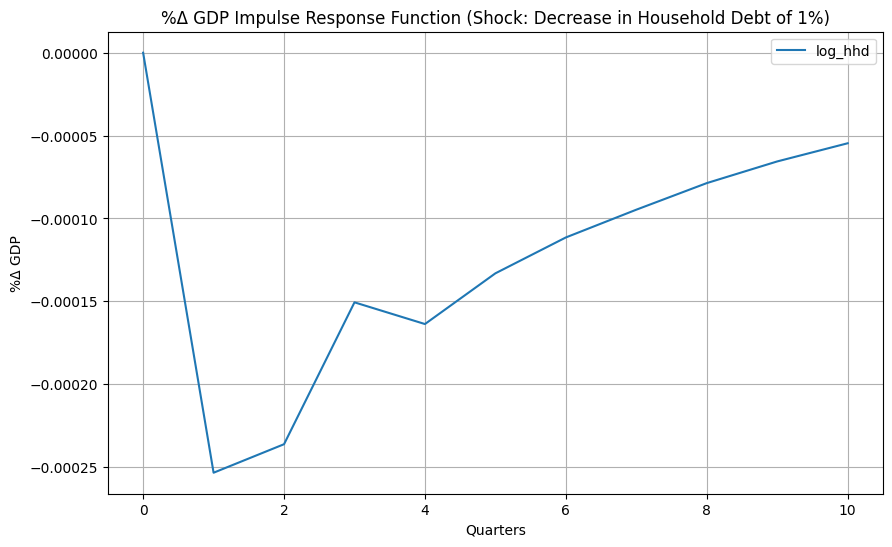

In [ ]:
plot4_irf_results = irf.predict(df_zeros, inputs, 'household_debt_lag1', -.2, 'log_GDP', 10, model_scaler_dict)
plot4_title = '%Δ GDP Impulse Response Function (Shock: Decrease in Household Debt of 1%)'
plot4_var = '%Δ GDP'


irf.plot(plot4_irf_results, 'log_hhd', plot4_title, plot4_var)

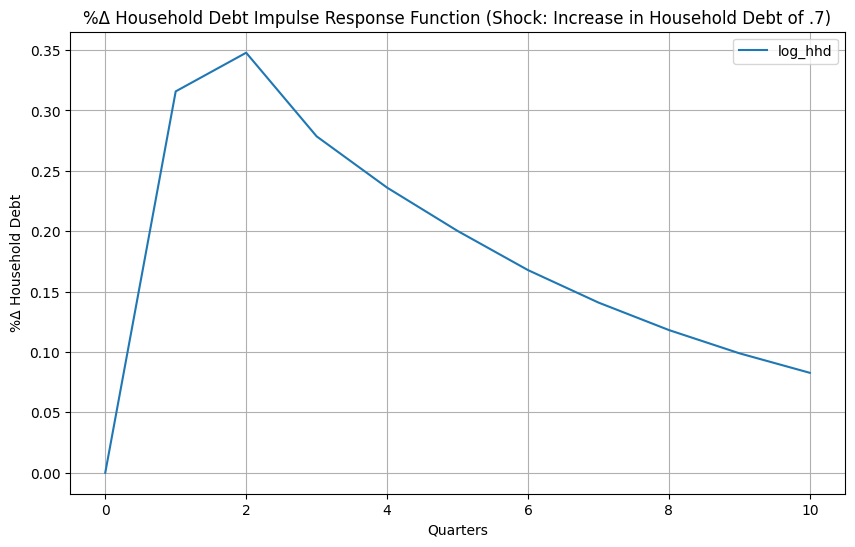

In [ ]:
plot5_irf_results = irf.predict(df_zeros, inputs, 'household_debt_lag1', .7, 'household_debt', 10, model_scaler_dict)
plot5_title = '%Δ Household Debt Impulse Response Function (Shock: Increase in Household Debt of .7)'
plot5_var = '%Δ Household Debt'


irf.plot(plot5_irf_results, 'log_hhd', plot5_title, plot5_var)

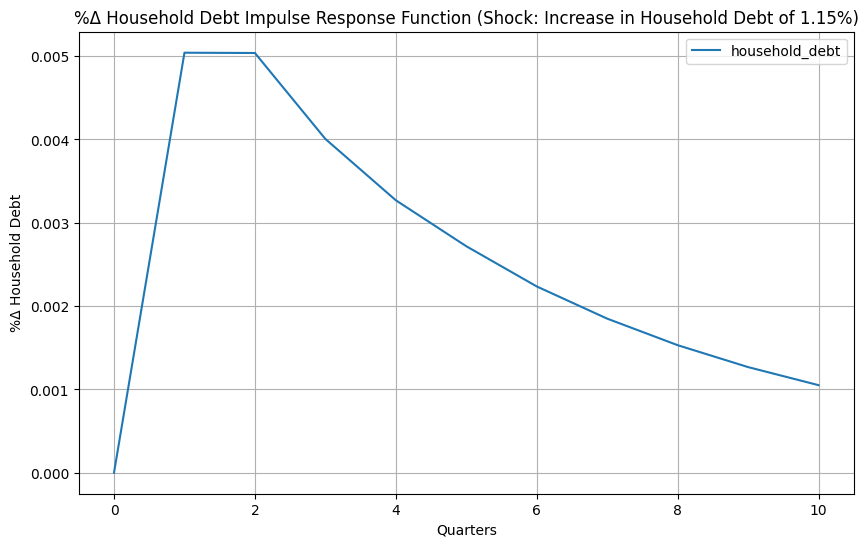

In [ ]:
plot6_irf_results = irf.predict(df_zeros, inputs, 'household_debt_lag1', .0115, 'household_debt', 10, model_scaler_dict)
plot6_title = '%Δ Household Debt Impulse Response Function (Shock: Increase in Household Debt of 1.15%)'
plot6_var = '%Δ Household Debt'


irf.plot(plot6_irf_results, 'household_debt', plot6_title, plot6_var)


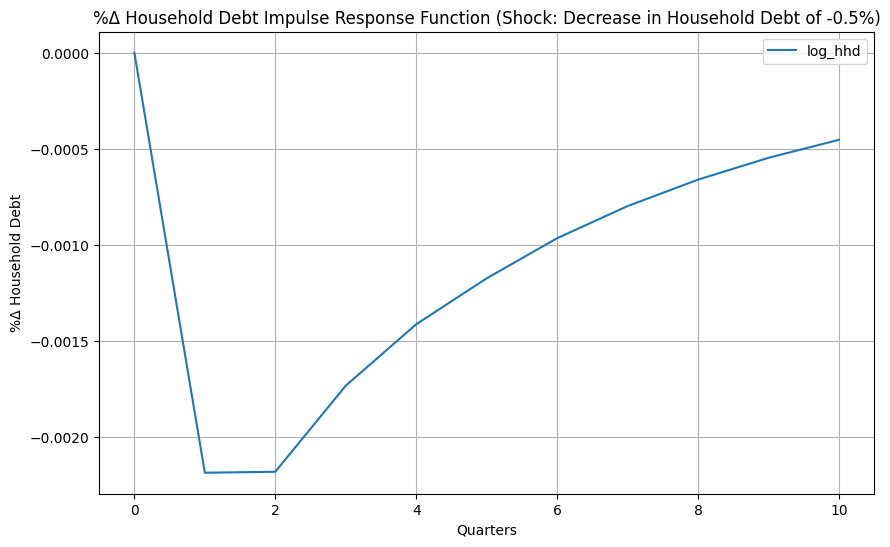

In [ ]:
plot6_irf_results = irf.predict(df_zeros, inputs, 'household_debt_lag1', -.005, 'household_debt', 10, model_scaler_dict)
plot6_title = '%Δ Household Debt Impulse Response Function (Shock: Decrease in Household Debt of -0.5%)'
plot6_var = '%Δ Household Debt'


irf.plot(plot6_irf_results, 'log_hhd', plot6_title, plot6_var)

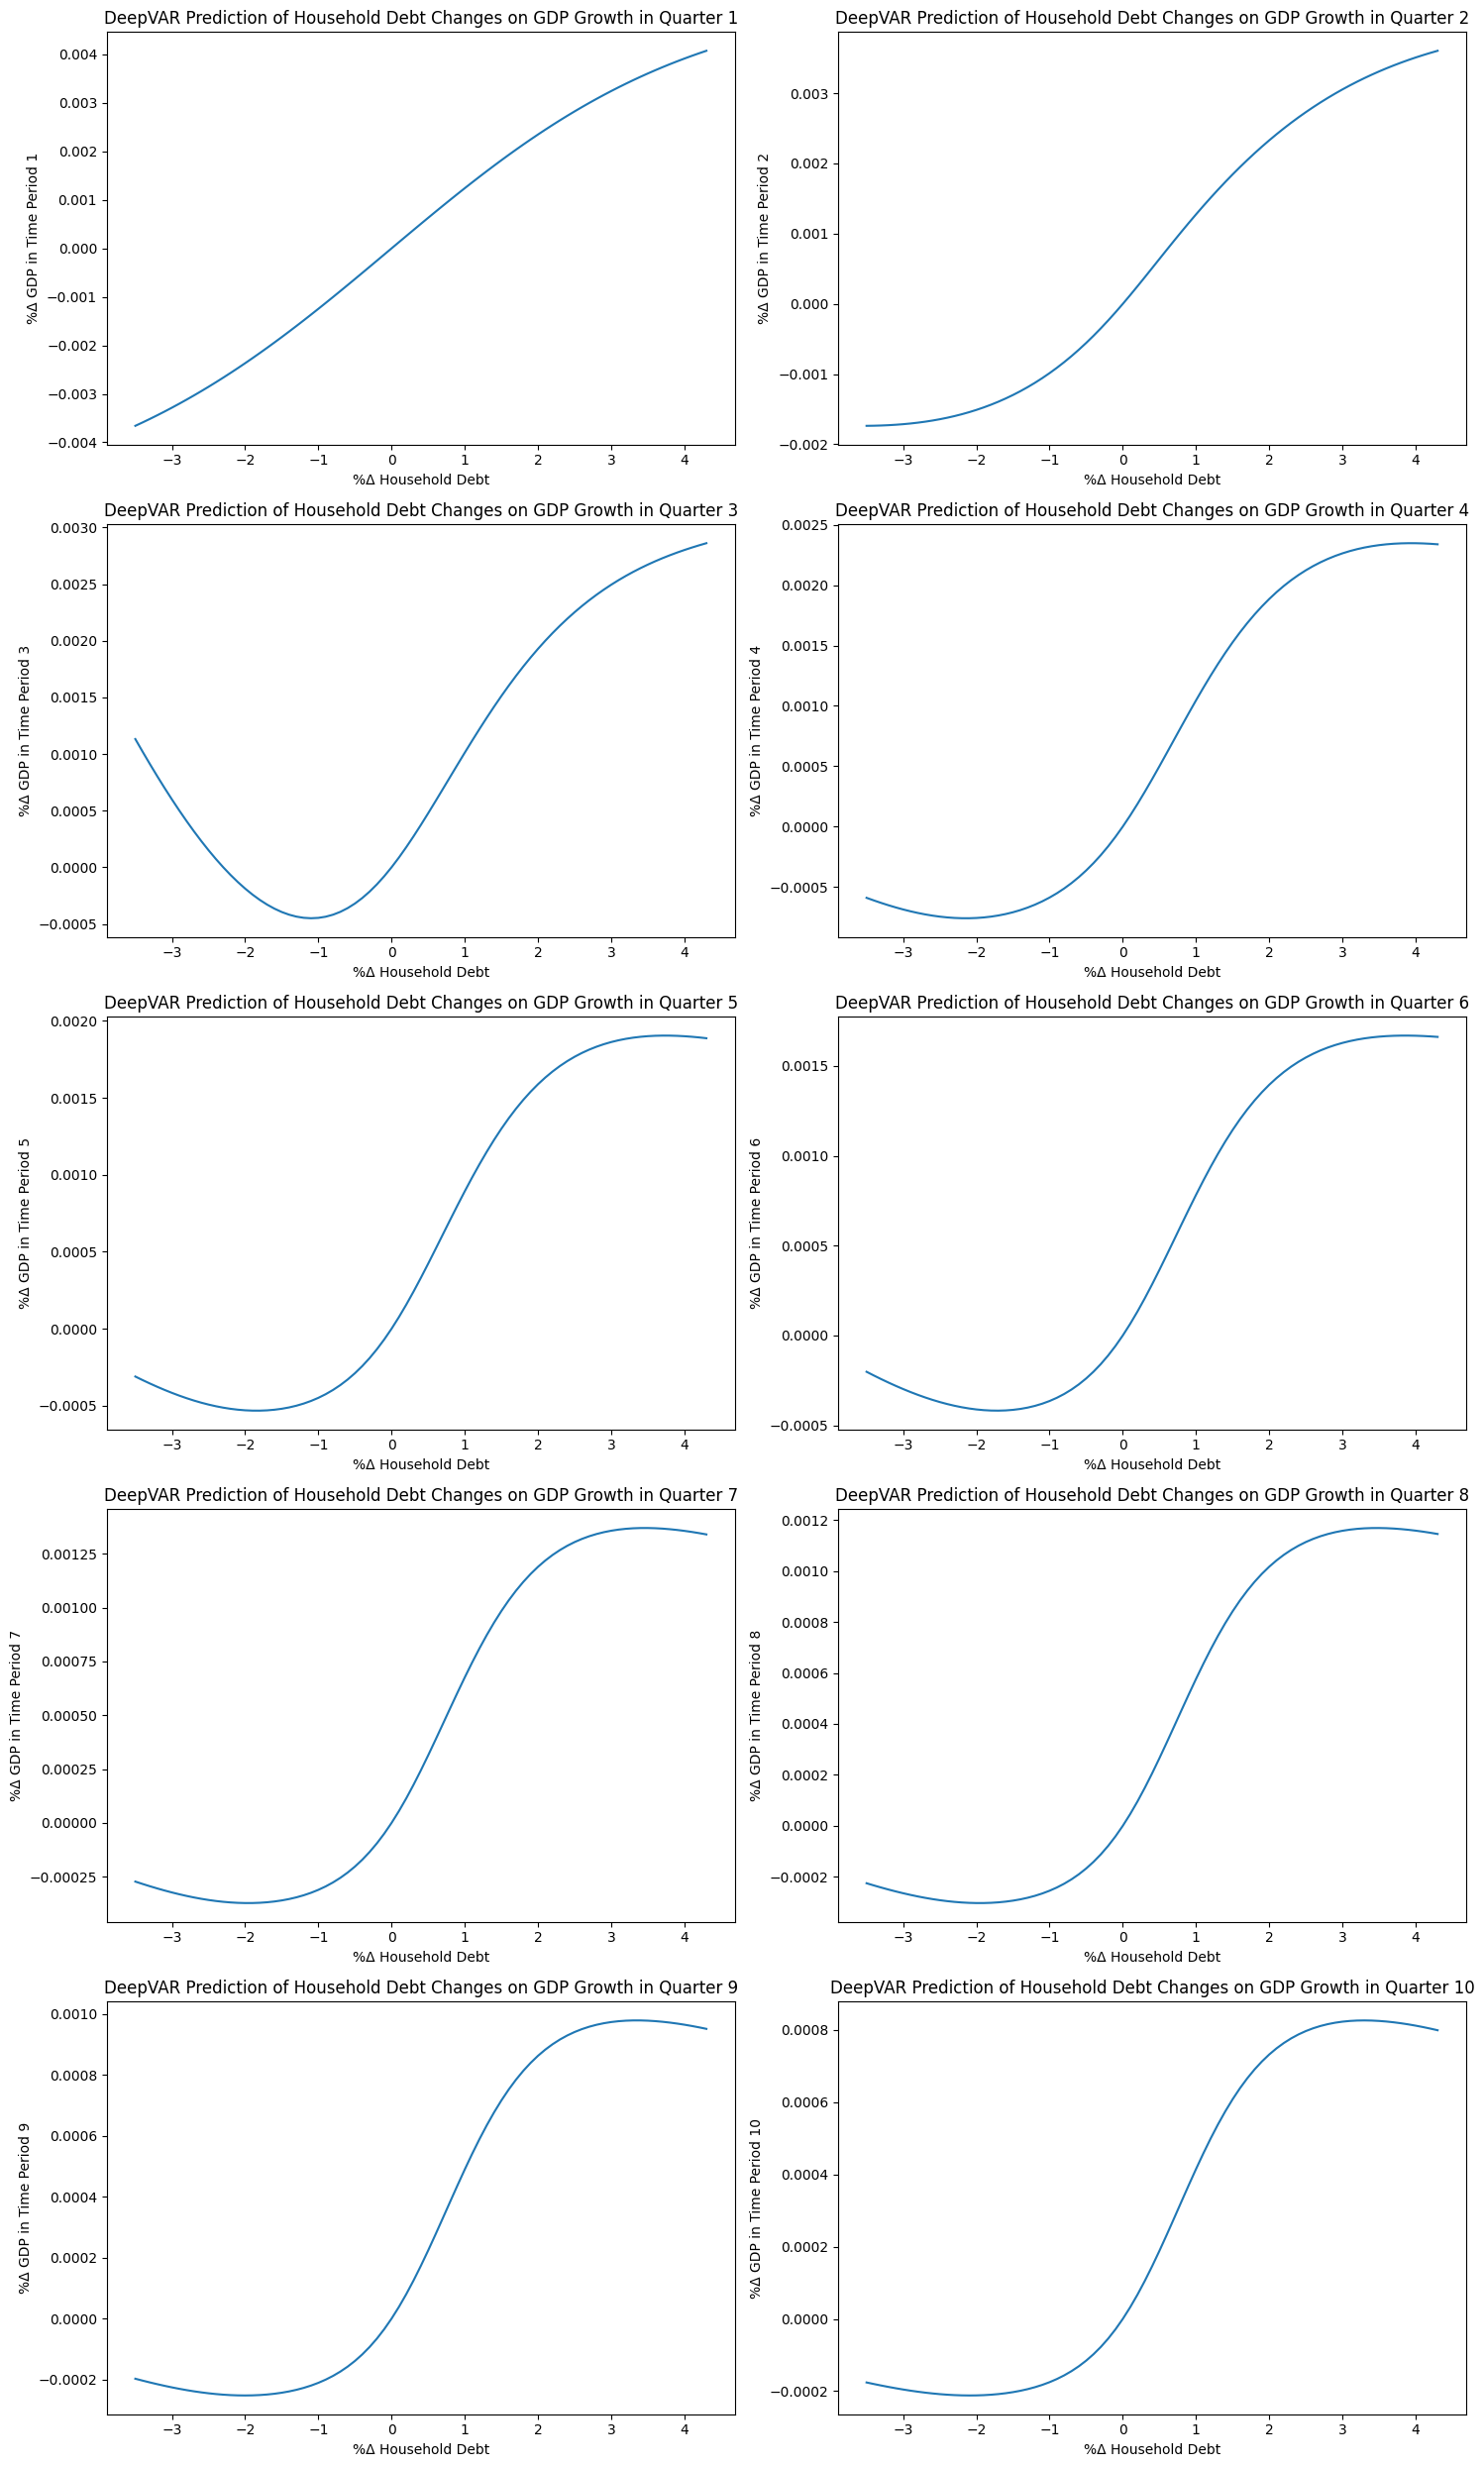

In [ ]:
onesteppredictions = []
twosteppredictions = []
threesteppredictions = []
foursteppredictions = []
fivesteppredictions = []
sixsteppredictions = []
sevensteppredictions = []
eightsteppredictions = []
ninesteppredictions = []
tensteppredictions = []
index = []
for num in np.arange(-3.5,4.4, 0.1):
    prediction = irf.predict(df_zeros, inputs, 'household_debt_lag1', num, 'log_GDP', 10, model_scaler_dict)
    # irf begins at 0 
    onesteppredictions.append(prediction[1])
    twosteppredictions.append(prediction[2])
    threesteppredictions.append(prediction[3])
    foursteppredictions.append(prediction[4])
    fivesteppredictions.append(prediction[5])
    sixsteppredictions.append(prediction[6])
    sevensteppredictions.append(prediction[7])
    eightsteppredictions.append(prediction[8])
    ninesteppredictions.append(prediction[9])
    tensteppredictions.append(prediction[10])
    index.append(num)



fig, axs = plt.subplots(5, 2, figsize=(15, 25))  # 5x2 grid of subplots
axs = axs.ravel()  # Flatten the 2D array of axes for easier indexing

predictions_list = [onesteppredictions, twosteppredictions, threesteppredictions, 
                   foursteppredictions, fivesteppredictions, sixsteppredictions,
                   sevensteppredictions, eightsteppredictions, ninesteppredictions,
                   tensteppredictions]

for i in range(10):
    axs[i].plot(index, predictions_list[i])
    axs[i].set_xlabel("%Δ Household Debt")
    axs[i].set_ylabel(f"%Δ GDP in Time Period {i+1}")
    axs[i].set_title(f"DeepVAR Prediction of Household Debt Changes on GDP Growth in Quarter {i+1}")

plt.tight_layout() 
plt.show()

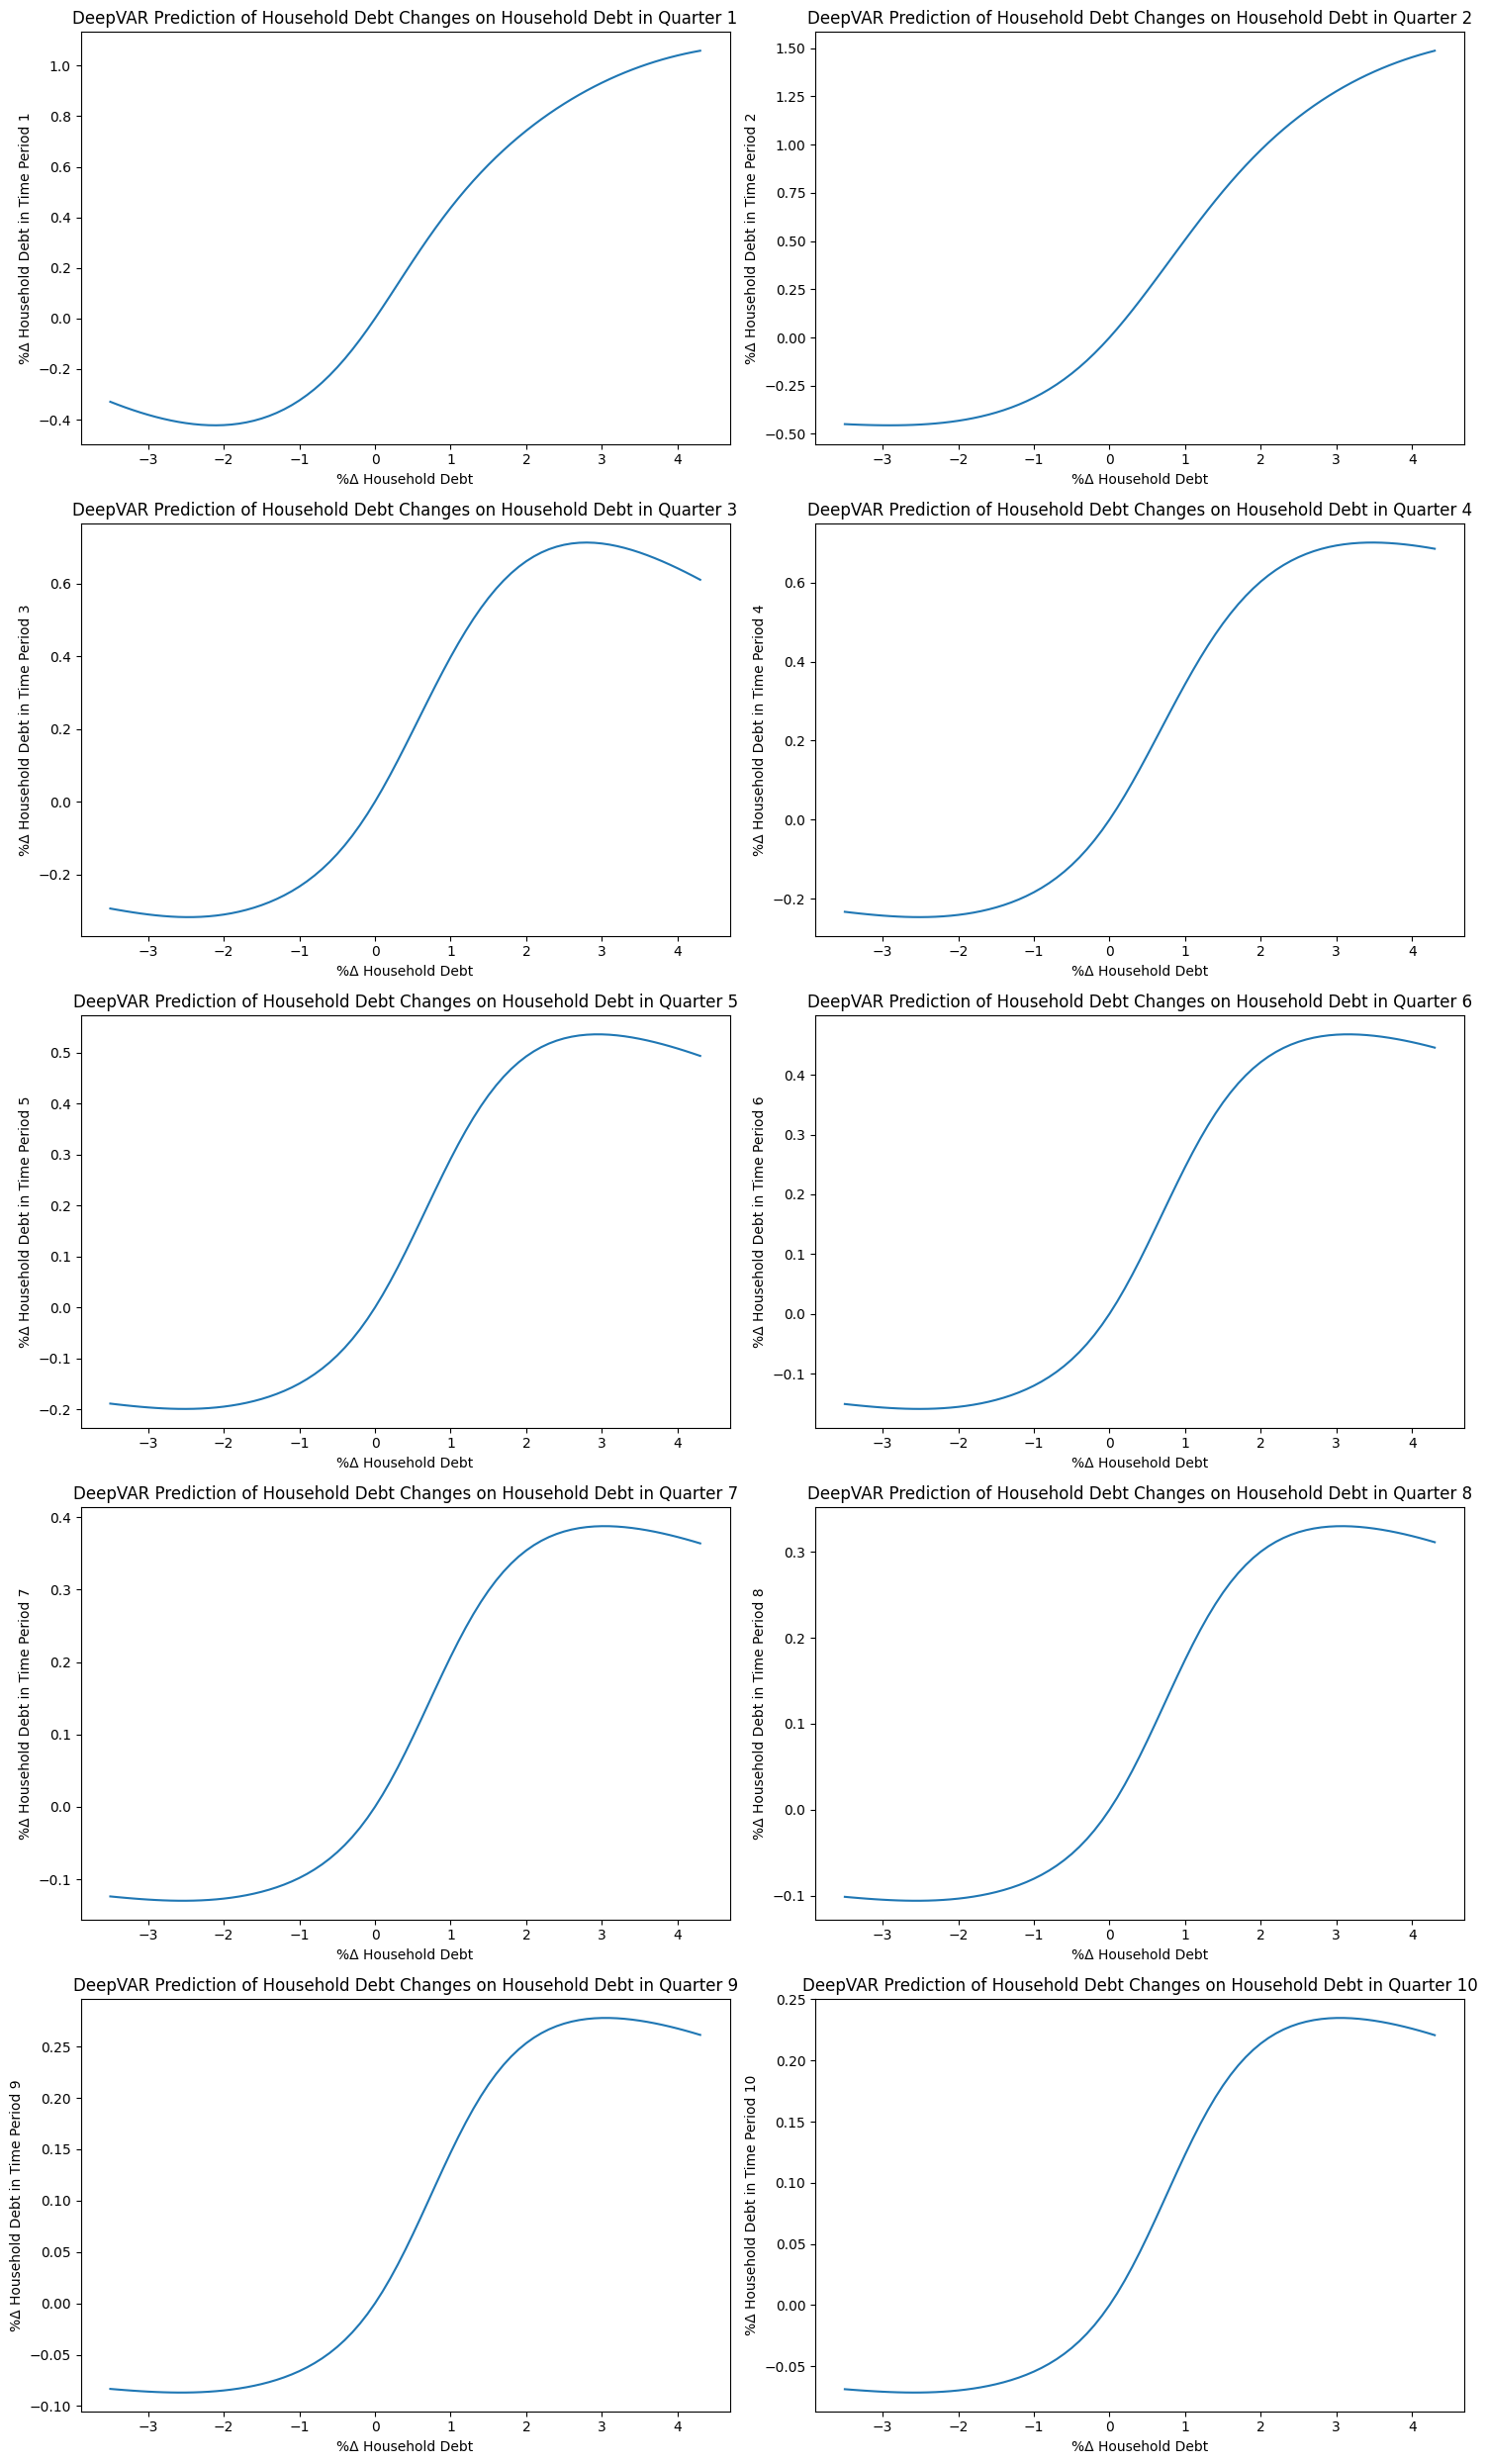

In [ ]:
onesteppredictions = []
twosteppredictions = []
threesteppredictions = []
foursteppredictions = []
fivesteppredictions = []
sixsteppredictions = []
sevensteppredictions = []
eightsteppredictions = []
ninesteppredictions = []
tensteppredictions = []
index = []
for num in np.arange(-3.50000, 4.4, .1):
    prediction = irf.predict(df_zeros, inputs, 'household_debt_lag1', num, 'household_debt', 10, model_scaler_dict)
    # irf begins at 0 
    onesteppredictions.append(prediction[1])
    twosteppredictions.append(prediction[2])
    threesteppredictions.append(prediction[3])
    foursteppredictions.append(prediction[4])
    fivesteppredictions.append(prediction[5])
    sixsteppredictions.append(prediction[6])
    sevensteppredictions.append(prediction[7])
    eightsteppredictions.append(prediction[8])
    ninesteppredictions.append(prediction[9])
    tensteppredictions.append(prediction[10])
    index.append(num)



fig, axs = plt.subplots(5, 2, figsize=(15, 25))  # 5x2 grid of subplots
axs = axs.ravel()  # Flatten the 2D array of axes for easier indexing

predictions_list = [onesteppredictions, twosteppredictions, threesteppredictions, 
                   foursteppredictions, fivesteppredictions, sixsteppredictions,
                   sevensteppredictions, eightsteppredictions, ninesteppredictions,
                   tensteppredictions]

for i in range(10):
    axs[i].plot(index, predictions_list[i])
    axs[i].set_xlabel("%Δ Household Debt")
    axs[i].set_ylabel(f"%Δ Household Debt in Time Period {i+1}")
    axs[i].set_title(f"DeepVAR Prediction of Household Debt Changes on Household Debt in Quarter {i+1}")

plt.tight_layout() 
plt.show()

In [36]:
# onesteppredictions = []
# twosteppredictions = []
# threesteppredictions = []
# foursteppredictions = []
# fivesteppredictions = []
# sixsteppredictions = []
# sevensteppredictions = []
# eightsteppredictions = []
# ninesteppredictions = []
# tensteppredictions = []
# index = []
# for num in np.arange(-3.50000,4.4, 0.1):
#     prediction = irf.predict(df_zeros, inputs, 'household_debt_lag1', num, 'log_CPI', 10, model_scaler_dict)
#     # irf begins at 0 
#     onesteppredictions.append(prediction[1])
#     twosteppredictions.append(prediction[2])
#     threesteppredictions.append(prediction[3])
#     foursteppredictions.append(prediction[4])
#     fivesteppredictions.append(prediction[5])
#     sixsteppredictions.append(prediction[6])
#     sevensteppredictions.append(prediction[7])
#     eightsteppredictions.append(prediction[8])
#     ninesteppredictions.append(prediction[9])
#     tensteppredictions.append(prediction[10])
#     index.append(num)



# fig, axs = plt.subplots(5, 2, figsize=(15, 25))  # 5x2 grid of subplots
# axs = axs.ravel()  # Flatten the 2D array of axes for easier indexing

# predictions_list = [onesteppredictions, twosteppredictions, threesteppredictions, 
#                    foursteppredictions, fivesteppredictions, sixsteppredictions,
#                    sevensteppredictions, eightsteppredictions, ninesteppredictions,
#                    tensteppredictions]

# for i in range(10):
#     axs[i].plot(index, predictions_list[i])
#     axs[i].set_xlabel("%Δ Household Debt")
#     axs[i].set_ylabel(f"%Δ CPI in Time Period {i+1}")
#     axs[i].set_title(f"DeepVAR Prediction of Household Debt Changes on CPI in Quarter {i+1}")

# plt.tight_layout() 
# plt.show()

In [37]:
au = hp.get_country(final_detrend, 'Australia')
au[au.index.get_level_values('TIME_PERIOD') == '2008-03-31']

log_GDP  household_debt  private_debt
Country   TIME_PERIOD                                       
Australia 2008-03-31   0.01071             0.1           0.9

In [208]:
balanced_data = pd.read_csv('./balanced_data.csv')
balanced_data = balanced_data[['country', 'quarter', 'l_GDP_dif', 'hd_dif', 'pd_dif']]
balanced_data = balanced_data.dropna()

balanced_data


country quarter  l_GDP_dif    hd_dif    pd_dif
0         Argentina  2008q2   0.003586  0.100000 -1.299999
1         Argentina  2008q3   0.007642 -0.100000 -0.200001
2         Argentina  2008q4  -0.046987  0.200000  0.100000
3         Argentina  2009q1  -0.036652 -0.100000  0.500000
4         Argentina  2009q2  -0.024878  0.000000  0.200001
...             ...     ...        ...       ...       ...
2413  United States  2022q3   0.006564 -0.299995 -1.200005
2414  United States  2022q4   0.006334 -0.500000 -0.799995
2415  United States  2023q1   0.005548 -1.200005 -0.400002
2416  United States  2023q2   0.005098 -0.399994 -1.000000
2417  United States  2023q3   0.011868 -0.500000 -1.000000

[2418 rows x 5 columns]